In [218]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import  ConstantKernel as C
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel,PairwiseKernel)
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import ensemble
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.model_selection import KFold

In [223]:
def log_returns(x, lag=1):
    """Calculate log returns between adjacent close prices"""
    return np.log(x) - np.log(x.shift(lag))

def calc_transform(df):
    """Calculate the transforms of raw features and add them to df"""
    # sort the df
    df.sort_index(ascending=True, inplace=True)
    df = df['CLOSE'].to_frame()
    name = 'CLOSE'

    # calculate percentage change and deciles
    pct_change = df[name].pct_change()
    df['pct_change'] = pct_change
    df['decile'] = calc_quantile(df[name], num_quantiles=10)
    df['pct_change_decile'] = calc_quantile(df['pct_change'], num_quantiles=10)
        
    #calculate ewma crossover

    for subset in itertools.combinations(_EWMA_HALF_LIVES, 2):
        ewma_crossover = ewma(pct_change, subset[0]) - ewma(pct_change, subset[1])
        ewma_crossover[:subset[1]] = np.NaN
        df['ewma_%s' % subset[0]+'-'+'ewma_%s' % subset[1]] = ewma_crossover
    df.fillna(method='ffill')
    
    return df

_EWMA_HALF_LIVES = [1, 5, 22, 66]

def calc_quantile(df, num_quantiles=10):
    """Returns quantile of each value"""
    # calculate quantiles
    out = df.rank(pct=True) * 100. // num_quantiles
    # For single sample (with largest value) with decile of 10 - decremement to 9
    out.loc[out == num_quantiles] = num_quantiles - 1
    return out

def ewma(x, halflife=11.2):
    # calculate exponentially weighted moving average
    if halflife == 0.:
        return x
    else:
        return x.ewm(halflife=halflife, adjust=False).mean()

In [224]:
INPUT_DIR = '/Users/chenbaolin/Desktop/project/tristan_project/Code' + '/eikon/'
SHFE_CU1 = 'cu_shfe_prices.csv' 
SHFE_AL1 = 'al_shfe_prices.csv'
CU_LME_STOCKS = 'cu_lme_stocks.csv'
CU_LME_PRICES = 'cu_lme_prices.csv'
TED = 'ted.csv'
TED_SPREAD = 'ted_spread.csv'
BDI = 'bdi.csv'
VIX = 'vix.csv'
GSCI = 'gsci.csv'
AL_LME_STOCKS = 'al_lme_stocks.csv'
AL_LME_PRICES = 'al_lme_prices.csv'

_EWMA_HALF_LIVES = [1, 5, 22, 66]

def load_daily_features_with_transforms():
    # Read in all raw predictors
    shfe_cu1 = pd.read_csv(INPUT_DIR + SHFE_CU1, index_col=0, parse_dates=True).sort_index(
            ascending=True)
    shfe_al1 = pd.read_csv(INPUT_DIR + SHFE_AL1, index_col=0, parse_dates=True).sort_index(
            ascending=True)
    cu_lme_stocks = pd.read_csv(INPUT_DIR + CU_LME_STOCKS, index_col=0, parse_dates=True).sort_index(
            ascending=True)
    cu_lme_prices = pd.read_csv(INPUT_DIR + CU_LME_PRICES, index_col=0, parse_dates=True).sort_index(
            ascending=True)
    ted = pd.read_csv(INPUT_DIR + TED, index_col=0, parse_dates=True).sort_index(
            ascending=True)
    ted_spread = pd.read_csv(INPUT_DIR + TED_SPREAD, index_col=0, parse_dates=True).sort_index(
            ascending=True)
    bdi = pd.read_csv(INPUT_DIR + BDI, index_col=0, parse_dates=True).sort_index(
            ascending=True)
    vix = pd.read_csv(INPUT_DIR + VIX, index_col=0, parse_dates=True).sort_index(
            ascending=True)
    gsci = pd.read_csv(INPUT_DIR + GSCI, index_col=0, parse_dates=True).sort_index(
            ascending=True)
    al_lme_stocks = pd.read_csv(INPUT_DIR + AL_LME_STOCKS, index_col=0, parse_dates=True).sort_index(
            ascending=True)
    al_lme_prices = pd.read_csv(INPUT_DIR + AL_LME_PRICES, index_col=0, parse_dates=True).sort_index(
            ascending=True)
    
    # Add in transforms of raw features with which to augment feature set
    shfe_cu1 = calc_transform(shfe_cu1)    
    shfe_al1 = calc_transform(shfe_al1)
    cu_lme_stocks = calc_transform(cu_lme_stocks)  
    cu_lme_prices = calc_transform(cu_lme_prices)    
    ted = calc_transform(ted)    
    ted_spread = calc_transform(ted_spread)
    bdi = calc_transform(bdi)
    vix = calc_transform(vix)
    gsci = calc_transform(gsci)
    al_lme_stocks = calc_transform(al_lme_stocks)
    al_lme_prices = calc_transform(al_lme_prices)
    
    #shift stock price one day forward
    cu_lme_stocks = cu_lme_stocks.shift(1)
    al_lme_stocks = al_lme_stocks.shift(1)
    
    # calcualte the return 
    log_return_cu = log_returns(shfe_cu1['CLOSE'])
    log_return_al = log_returns(shfe_al1['CLOSE'])
    
    return shfe_cu1,shfe_al1,cu_lme_stocks,cu_lme_prices,\
    ted,ted_spread,bdi,vix,gsci,al_lme_stocks,al_lme_prices,\
    log_return_cu,log_return_al
    

In [225]:
shfe_cu1,shfe_al1,cu_lme_stocks,cu_lme_prices,\
ted,ted_spread,bdi,vix,gsci,al_lme_stocks,al_lme_prices,\
log_return_cu,log_return_al = load_daily_features_with_transforms()

In [226]:
def create_feature(lags,metal,correct_return_date = True):
    if metal=='cu':
    # Compile into single df
        df_ls = [cu_lme_stocks,cu_lme_prices,ted,ted_spread,bdi,vix,gsci]
        df_all = pd.concat(df_ls, axis=1)
        old_column = df_all.columns
        df_all = df_all.loc[:,(old_column != 'CLOSE')]

        # get all feature_name
        FULL_FEATURE_SET = []
        sub_feature_name = ['pct_change','decile','pct_change_decile','ewma_1-ewma_5','ewma_1-ewma_22',\
                           'ewma_1-ewma_66','ewma_5-ewma_22','ewma_5-ewma_66','ewma_22-ewma_66']
        feature_name = ['cu_lme_stocks_','cu_lme_prices_','ted_','ted_spread_','bdi_','vix_','gsci_']
        for feature in feature_name:
            for sub_feature in sub_feature_name:
                FULL_FEATURE_SET.append(feature + sub_feature)


        df_all.columns = FULL_FEATURE_SET
        df_Xy = pd.concat([df_all, log_return_cu.to_frame()], axis=1)
    else:
        # Compile into single df
        df_ls = [al_lme_stocks,al_lme_prices,ted,ted_spread,bdi,vix,gsci]
        df_all = pd.concat(df_ls, axis=1)
        old_column = df_all.columns
        df_all = df_all.loc[:,(old_column != 'CLOSE')]

        # get all feature_name
        FULL_FEATURE_SET = []
        sub_feature_name = ['pct_change','decile','pct_change_decile','ewma_1-ewma_5','ewma_1-ewma_22',\
                           'ewma_1-ewma_66','ewma_5-ewma_22','ewma_5-ewma_66','ewma_22-ewma_66']
        feature_name = ['al_lme_stocks_','al_lme_prices_','ted_','ted_spread_','bdi_','vix_','gsci_']
        for feature in feature_name:
            for sub_feature in sub_feature_name:
                FULL_FEATURE_SET.append(feature + sub_feature)


        df_all.columns = FULL_FEATURE_SET
        df_Xy = pd.concat([df_all, log_return_al.to_frame()], axis=1)
        

    # Remove any rows with missing output values
    df_Xy.dropna(axis=0, how='any', subset=['CLOSE'], inplace=True)

    # Do not ffill for values where outside the date range of any features
    # Find first and last dates for which all features available
    start_date = df_Xy.loc[df_Xy.notnull().all(axis=1)].index.min()
    end_date = df_Xy.loc[df_Xy.notnull().all(axis=1)].index.max()
    df_Xy = df_Xy.fillna(method='ffill')
    df_Xy = df_Xy.loc[start_date:end_date, :]

    if correct_return_date:
        # Move returns back one day so that features for today used to calculate tomorrow's return
        df_Xy['CLOSE'] = df_Xy['CLOSE'].shift(-lags)

    # Remove any rows with missing output values
    df_Xy.dropna(axis=0, how='any', subset=['CLOSE'], inplace=True)

    return df_Xy

In [227]:
cu_lag1 = create_feature(1,'cu')
cu_lag5 = create_feature(5,'cu')
cu_lag22 = create_feature(22,'cu')

al_lag1 = create_feature(1,'al')
al_lag5 = create_feature(5,'al')
al_lag22 = create_feature(22,'al')

In [228]:
print (cu_lag1.shape,cu_lag5.shape,cu_lag22.shape,al_lag1.shape,al_lag5.shape,al_lag22.shape)
#(2436, 73) (2432, 73) (2415, 73) (2809, 73) (2805, 73)

(2436, 64) (2432, 64) (2415, 64) (2809, 64) (2805, 64) (2788, 64)


# correlation betweem target and features

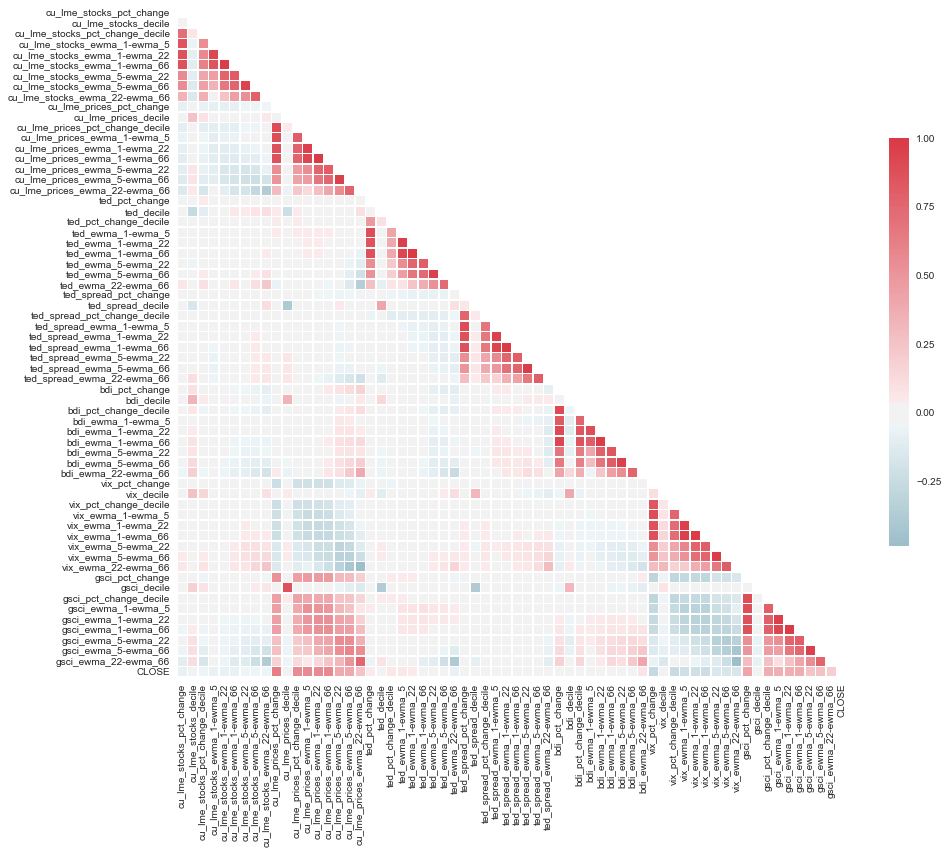

In [528]:
import seaborn as sns
from string import ascii_letters
sns.set(style="white")
corr = cu_lag1.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5,cbar_kws={"shrink": .5})
fig.savefig('al_lag1_corr2.png')
plt.show()

# gaussian regression model

In [236]:
#shuffle data and split data into training set and test set
def split_data(data,rio):
    X = data.drop(['CLOSE'],axis = 1)
    y = data['CLOSE']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=rio, random_state=42)
    return X_train,X_test, y_train, y_test

def gaussian_model(gp,data_set):
    result = {}
    for T,data in enumerate(data_set):
        # split data into training set and test set
        X_train,X_test,y_train,y_test = split_data(data,0.2)
        # build model
        gp.fit(X_train,y_train)
        test_y_pre = gp.predict(X_test)
        y_pre= gp.predict(X_train)
        # 
        corr_train,mse_train = criteria(y_train,y_pre)
        corr_test,mse_test = criteria(y_test,test_y_pre)
        result['feature%s'%T] = [corr_train,mse_train,corr_test,mse_test]

        print ("rank correlation and mse of training data:",corr_train,mse_train)
        print ("rank correlation and mse of test data:",corr_test,mse_test)
        print (gp.kernel_.get_params())
        
        plot_(y_train,y_pre,y_test,test_y_pre)
    return result

def criteria(y,y_pre):
    corr,_ =  stats.spearmanr(y_pre,y)
    mse = mean_squared_error(y_pre,y)
    return corr,mse

def plot_(y,y_pre,y_test,y_pre_test):
    
    y_pre = pd.Series(data = y_pre,index = y.index)
    y_pre_test = pd.Series(data = y_pre_test,index = y_test.index)
    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.plot(y_pre.sort_index(ascending=True))
    plt.plot(y.sort_index(ascending=True))
    plt.title('training set')
    plt.legend(['preidction','groud truth'],loc = 'upper center')
    plt.subplot(2,1,2)
    plt.plot(y_pre_test.sort_index(ascending=True))
    plt.plot(y_test.sort_index(ascending=True))
    plt.title('test set')
    plt.legend(['preidction','groud truth'],loc = 'upper center')
    plt.show()
    
def plot_table(result):
    temp = []
    for _,value in result.items():
        temp.append(value)
    temp = np.array(temp)

    df = pd.DataFrame(data = temp, index=['lag1','lag5','lag22'],\
                      columns=['train_correlation', 'train_mse','test_correlation','test_mse'])

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111,frameon=True, xticks=[], yticks=[])
    the_table=plt.table(cellText=df.values, rowLabels=df.index, colLabels=df.columns, 
                        colWidths = [0.1]*df.shape[1], loc='center',cellLoc='center')
    the_table.set_fontsize(20)
    the_table.scale(5,9)
    plt.show()
    
def selected_kernel(kernel_set,data,feature_list=None):
    kernel_result = {}
    X_train,X_test,y_train,y_test = split_data(data,0.2)
    if feature_list is not None:
        X_train = X_train[feature_list]
        X_test = X_test[feature_list]
    for kernel in kernel_set.keys():
        gp = GaussianProcessRegressor(kernel=kernel_set[kernel])
        gp.fit(X_train,y_train)
        y_pre_test = gp.predict(X_test)
        y_pre= gp.predict(X_train)
        
        corr_train,mse_train = criteria(y_train,y_pre)
        corr_test,mse_test = criteria(y_test,y_pre_test)
        kernel_result[kernel] = {}
        kernel_result[kernel]['result'] = [corr_train,mse_train,corr_test,mse_test]
        kernel_result[kernel]['model'] = gp
        
        print ("rank correlation and mse of training data:",corr_train,mse_train)
        print ("rank correlation and mse of test data:",corr_test,mse_test)

        plot_(y_train,y_pre,y_test,y_pre_test)
        
    return kernel_result

In [526]:
def plot_table_(result,table_y):
    
    df = pd.DataFrame(data = result, index = table_y,\
                      columns=['test_correlation','test_mse'])

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111,frameon=True, xticks=[], yticks=[])
    the_table=plt.table(cellText=df.values, rowLabels=df.index, colLabels=df.columns, 
                        colWidths = [0.1]*df.shape[1], loc='center',cellLoc='center')
    the_table.set_fontsize(20)
    the_table.scale(5,9)
    fig.savefig('all_gaussian_result.png')
    plt.show()

In [539]:
all_gaussian_result = []
table_y = []
for i in gaussian_result.keys():
    for j in gaussian_result[i].keys():
        table_y.append('%s+%s'%(i,j))
        all_gaussian_result.append(gaussian_result[i][j]['result'][2:])

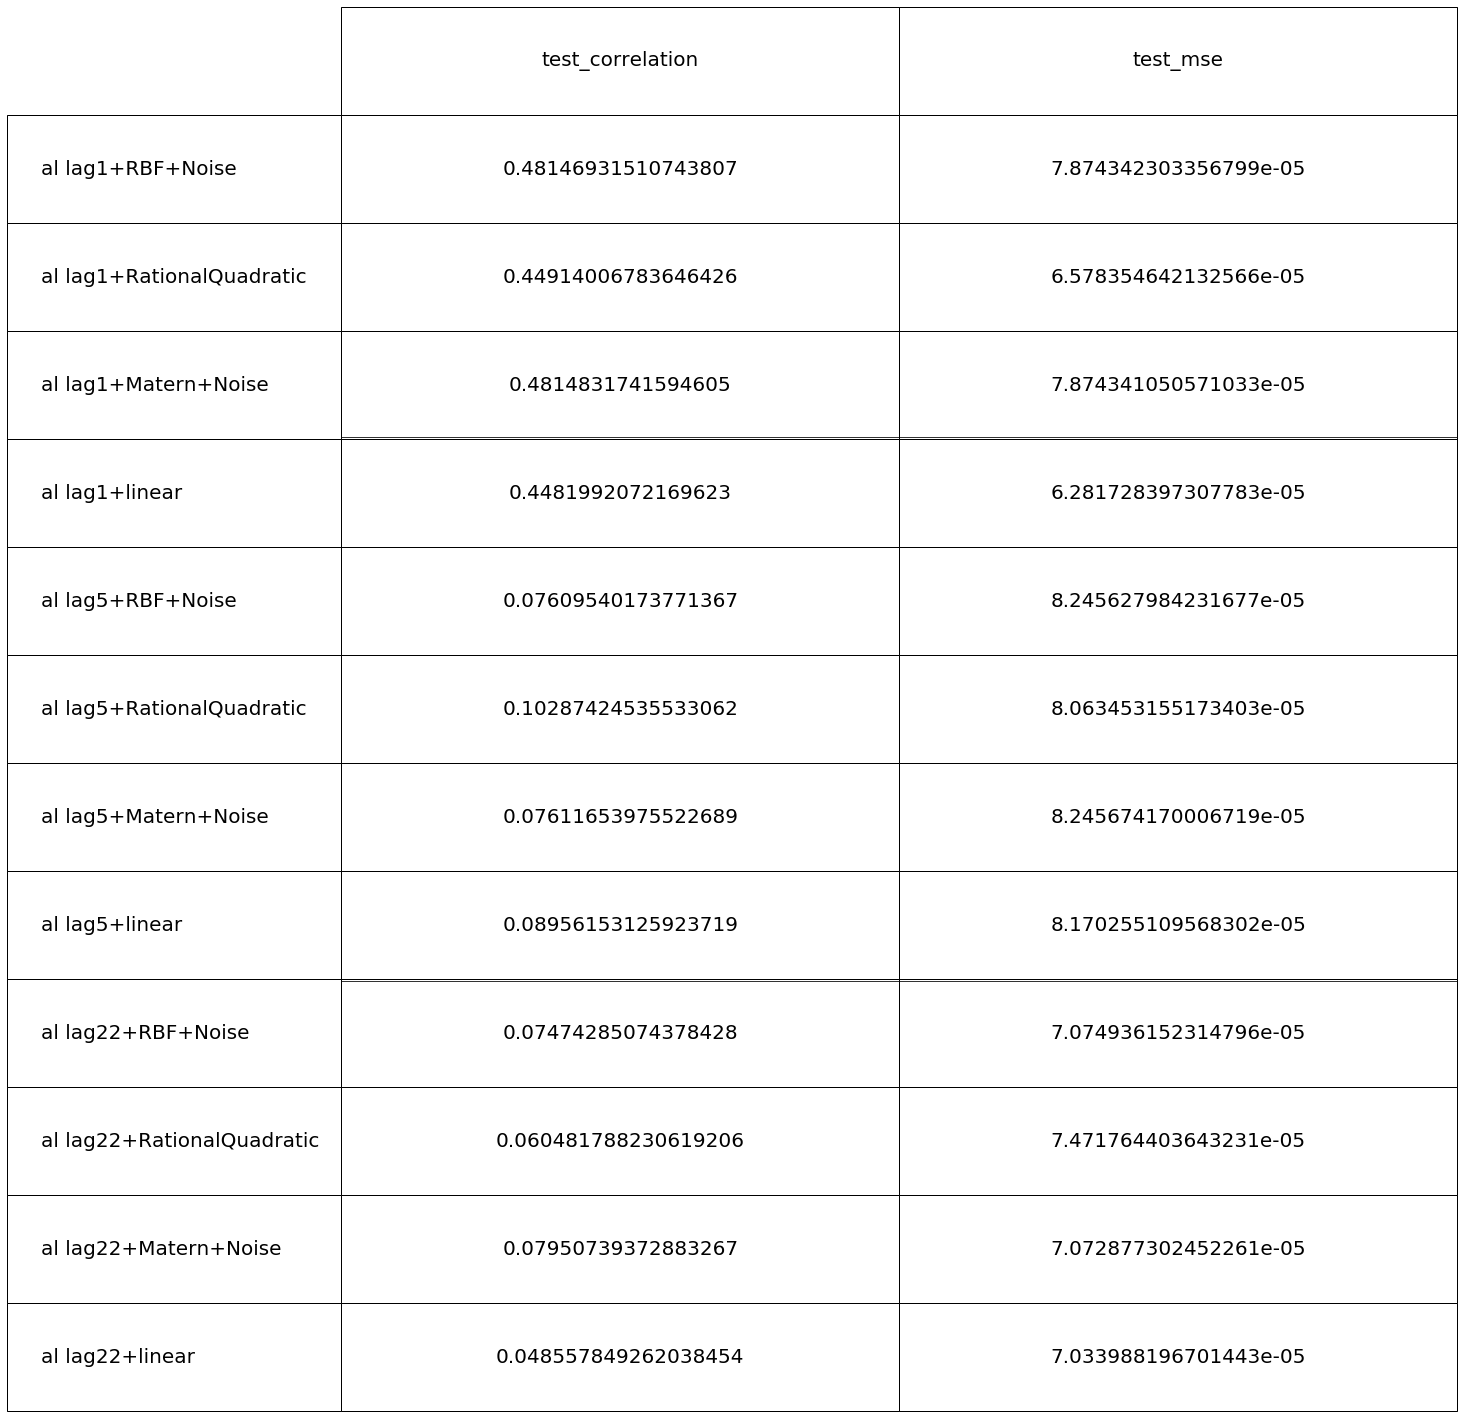

In [686]:
# all_gaussian_result = np.array(all_gaussian_result)
# all_gaussian_result[:,0] = np.around(np.array(all_gaussian_result)[:,0], decimals=3)
# all_gaussian_result[:,1] = np.around(np.array(all_gaussian_result)[:,1], decimals=8)

plot_table_(np.array(all_gaussian_result)[12:,:],table_y[12:])

In [511]:
gaussian_result2

{'al lag1': {'Matern+Noise1': {'model': GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5) + WhiteKernel(noise_level=0.0001),
                n_restarts_optimizer=0, normalize_y=False,
                optimizer='fmin_l_bfgs_b', random_state=None),
   'result': [0.13613211619628757,
    7.526328344008468e-05,
    0.17103385115645836,
    7.874191687659018e-05]},
  'RBF+Noise1': {'model': GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=0.0001),
                n_restarts_optimizer=0, normalize_y=False,
                optimizer='fmin_l_bfgs_b', random_state=None),
   'result': [0.13585745739733915,
    7.526390300394599e-05,
    0.17062801755015886,
    7.874282362975774e-05]}},
 'al lag22': {'Matern+Noise1': {'model': GaussianProcessRegressor(alpha=1e-10, c

rank correlation and mse of training data: 0.74596749503009 4.466314824803203e-05
rank correlation and mse of test data: 0.4889280339892235 0.000132275203359304


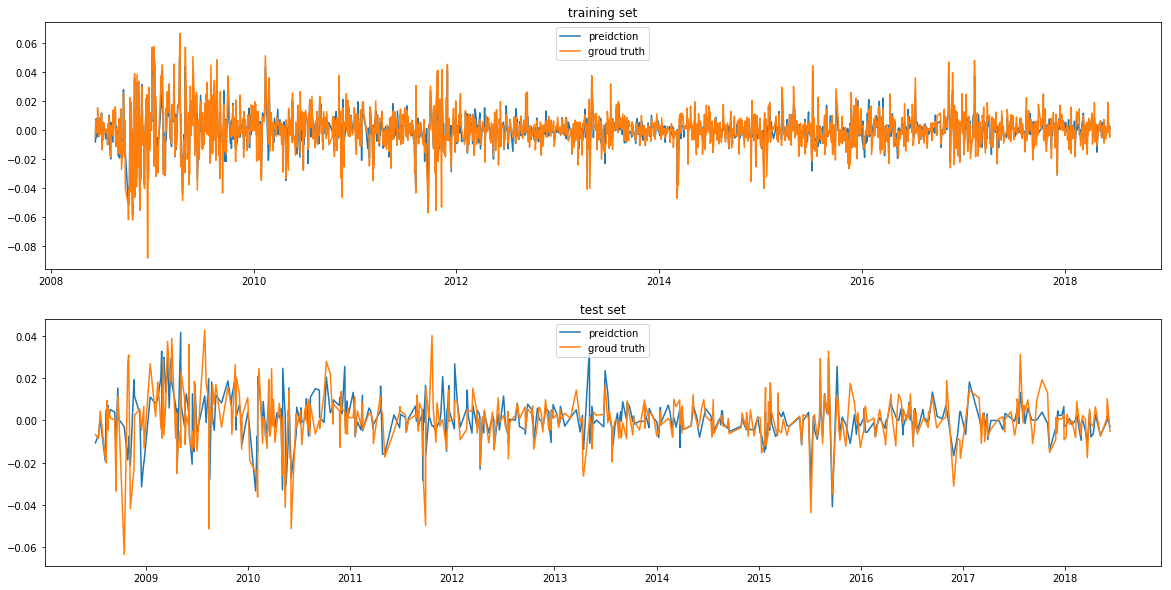

rank correlation and mse of training data: 0.8639513217100402 2.3094886788663697e-05
rank correlation and mse of test data: 0.4792768203439705 0.00013783131362236765


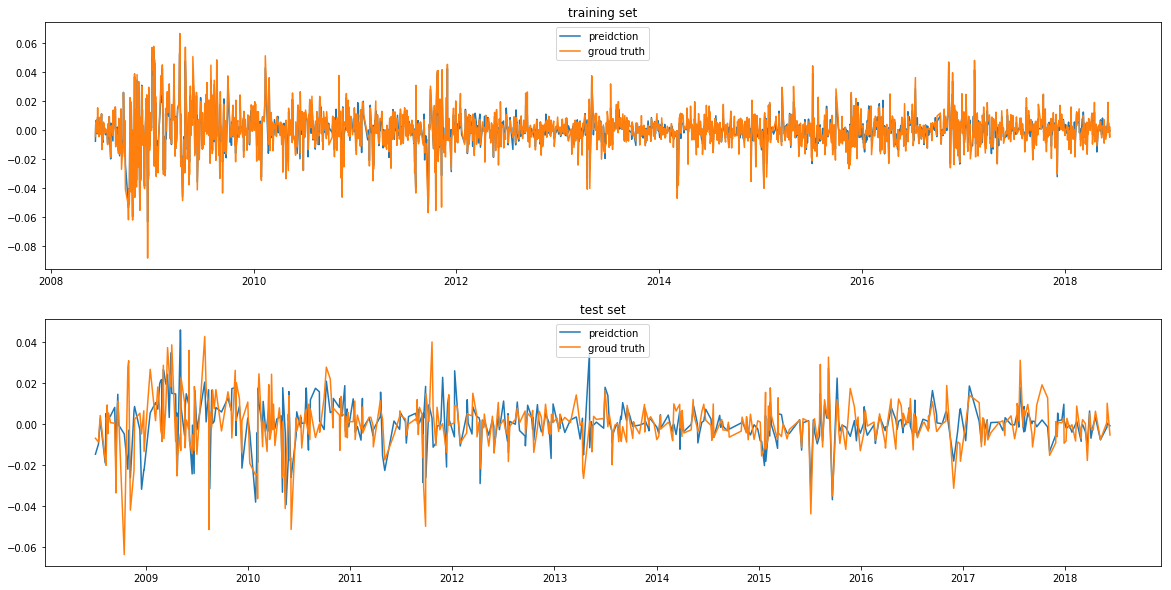

rank correlation and mse of training data: 0.02694203978955535 0.00016504318373603151
rank correlation and mse of test data: 0.0814755546297614 0.00016627429096362578


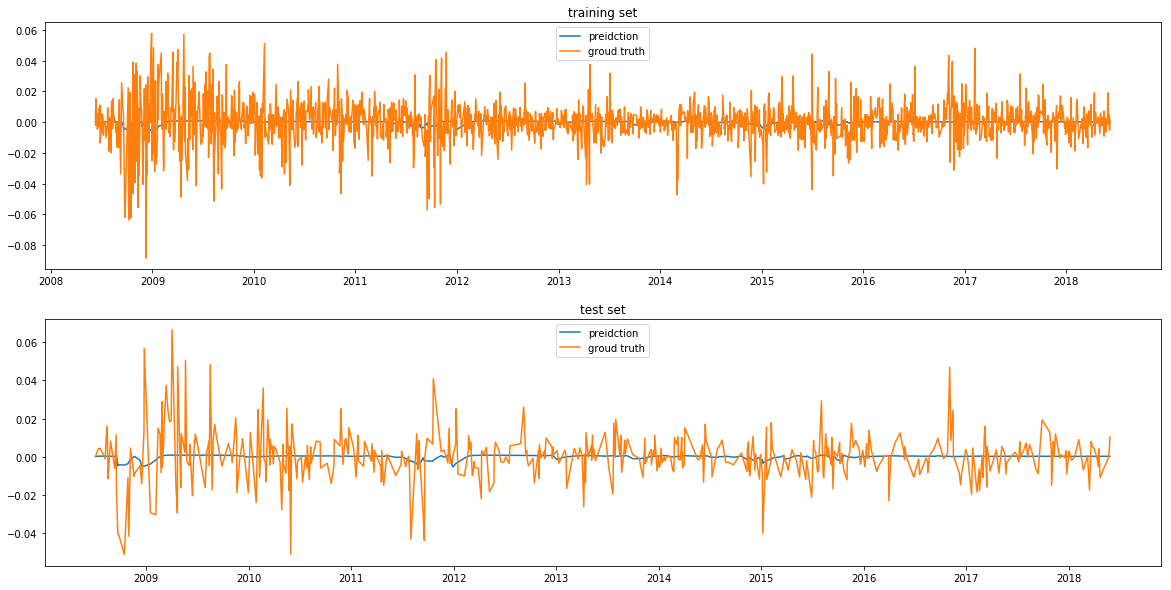

rank correlation and mse of training data: 0.026522710271259665 0.00016508341537522443
rank correlation and mse of test data: 0.08079368866193005 0.00016630127319688988


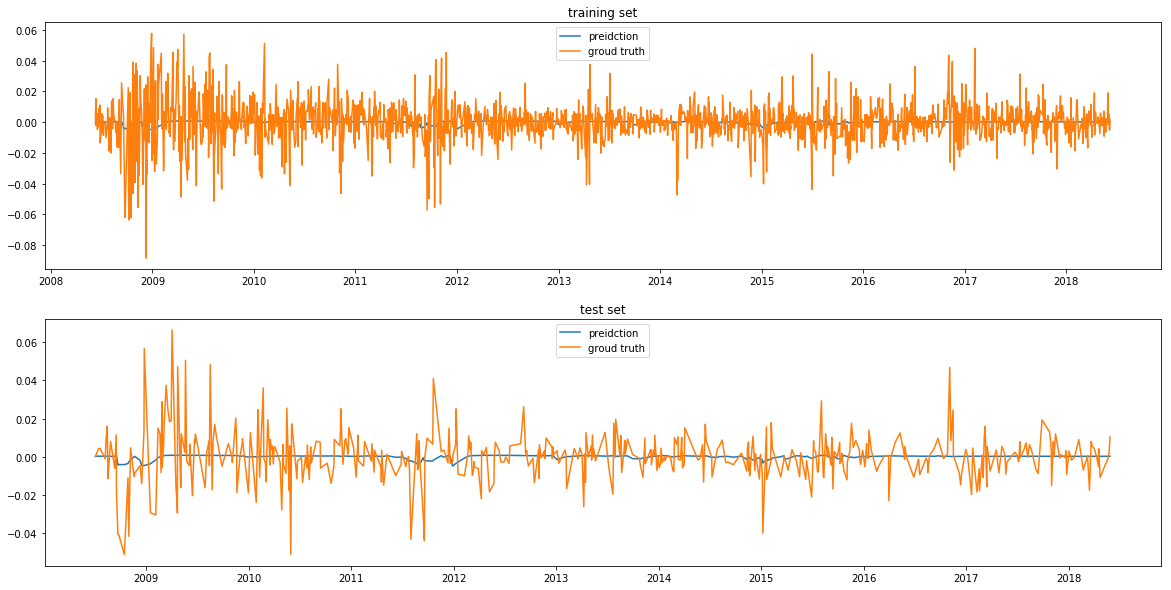

rank correlation and mse of training data: 0.20221595419596844 0.0001482965593006777
rank correlation and mse of test data: 0.03590063944431066 0.0001738906407320693


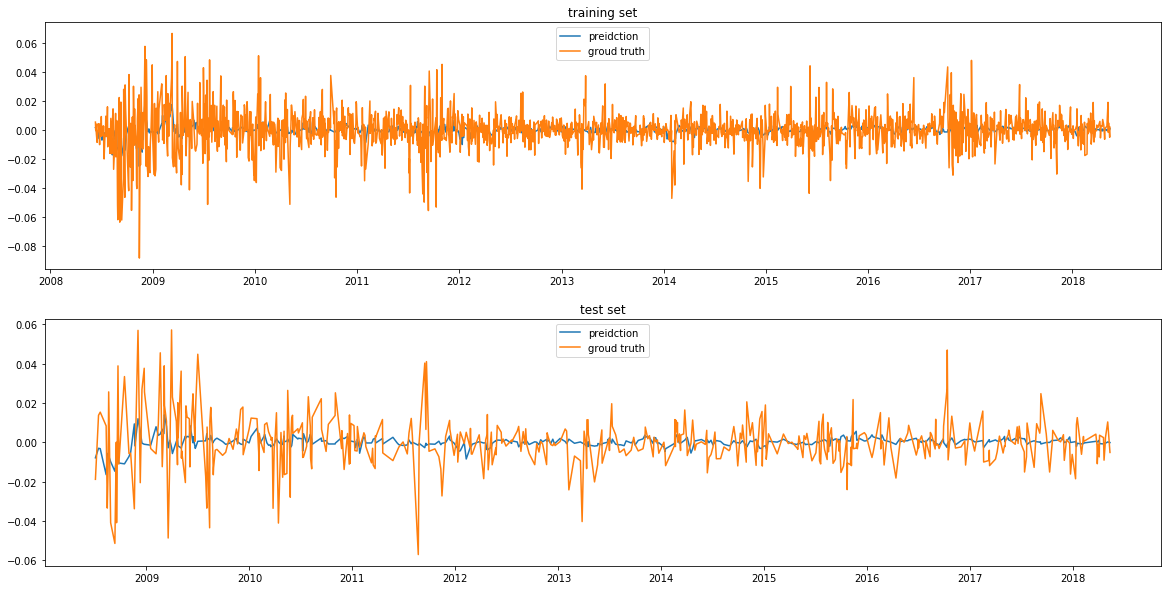

rank correlation and mse of training data: 0.2201135278498203 0.0001512964573345547
rank correlation and mse of test data: 0.028496567204575954 0.00017003247173594157


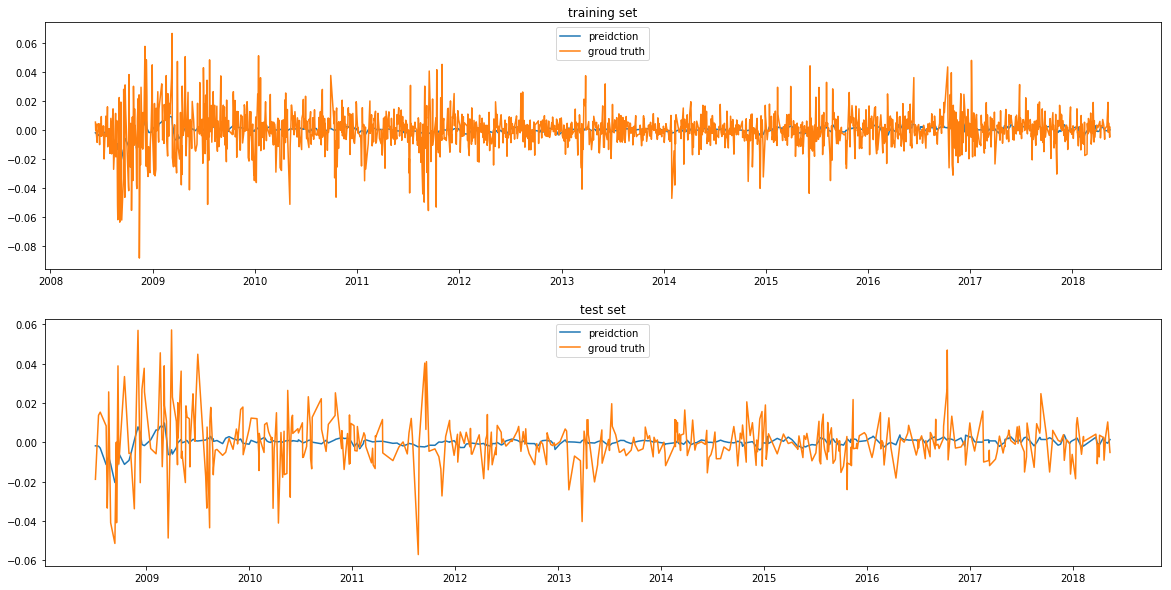

rank correlation and mse of training data: 0.13585745739733915 7.526390300394599e-05
rank correlation and mse of test data: 0.17062801755015886 7.874282362975774e-05


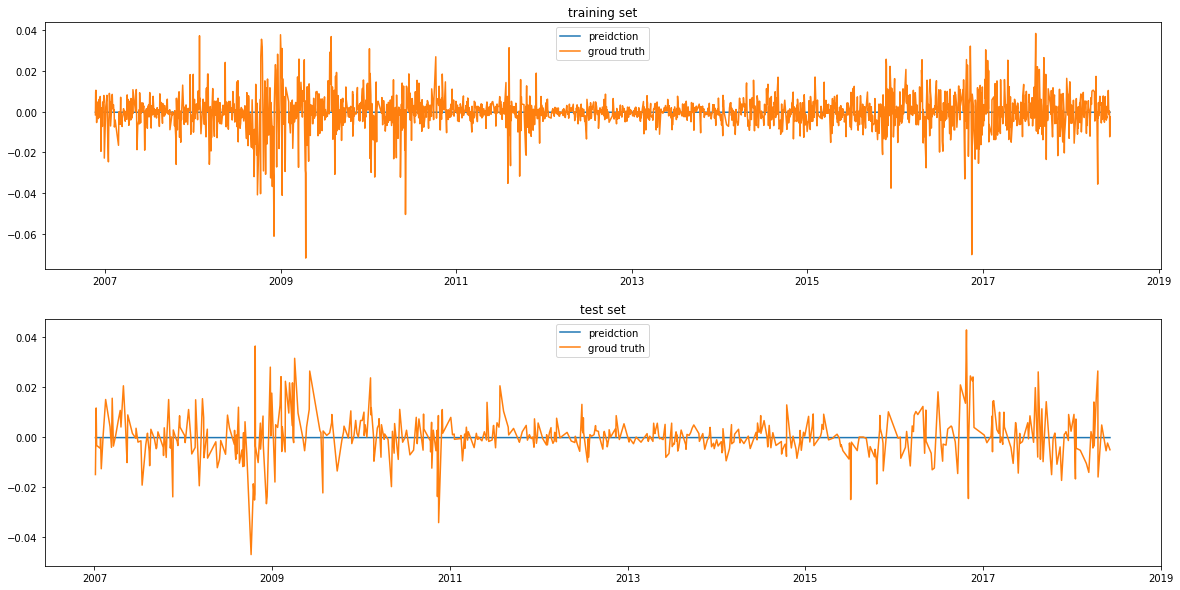

rank correlation and mse of training data: 0.13613211619628757 7.526328344008468e-05
rank correlation and mse of test data: 0.17103385115645836 7.874191687659018e-05


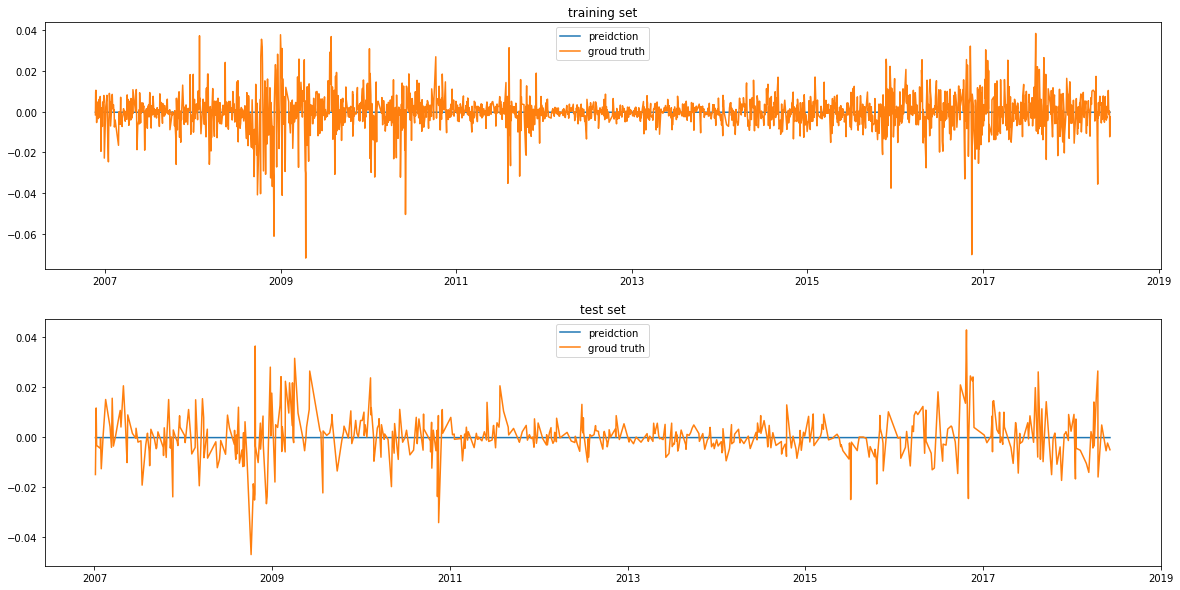

rank correlation and mse of training data: 0.04686771454776233 7.435384501767278e-05
rank correlation and mse of test data: -0.003626971152920152 8.245654628766717e-05


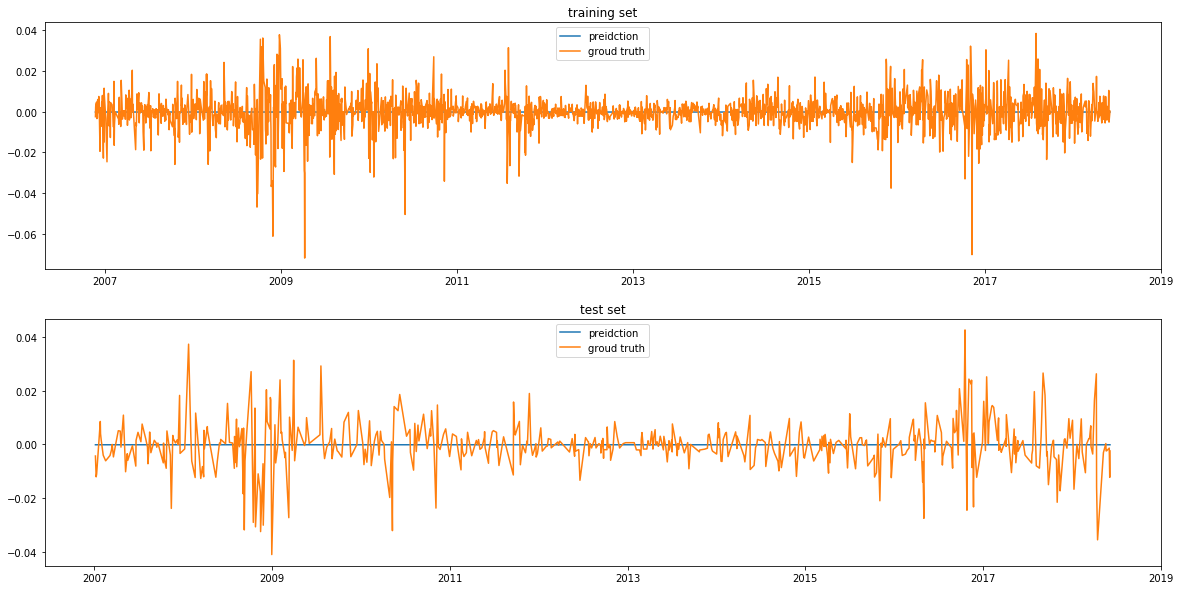

rank correlation and mse of training data: 0.04640933611427061 7.435368131552609e-05
rank correlation and mse of test data: -0.009563593566694383 8.245626790173381e-05


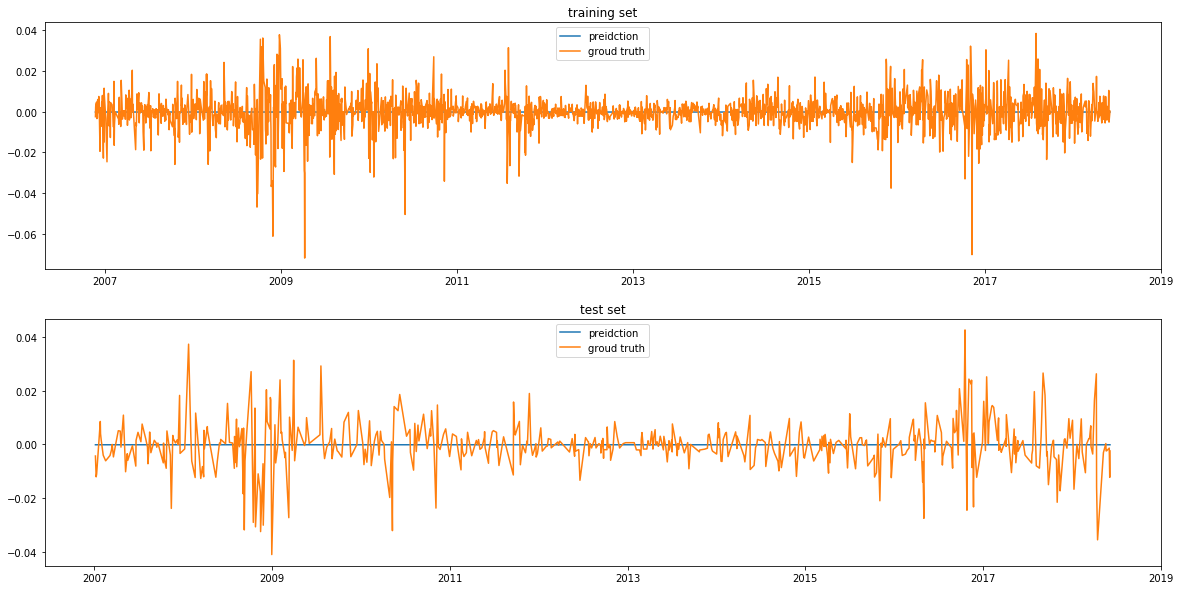

rank correlation and mse of training data: 0.04973377485134117 7.723445260509635e-05
rank correlation and mse of test data: 0.08984435539059488 7.055183348987628e-05


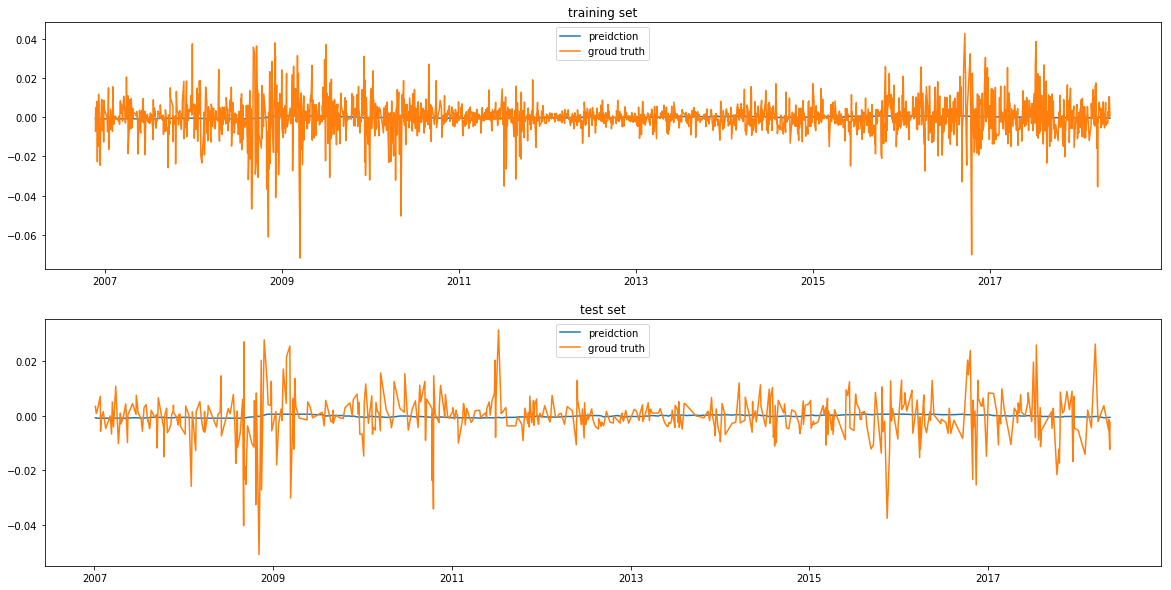

rank correlation and mse of training data: 0.08747836152247399 7.679915205729425e-05
rank correlation and mse of test data: 0.09753145163015867 7.068010302414519e-05


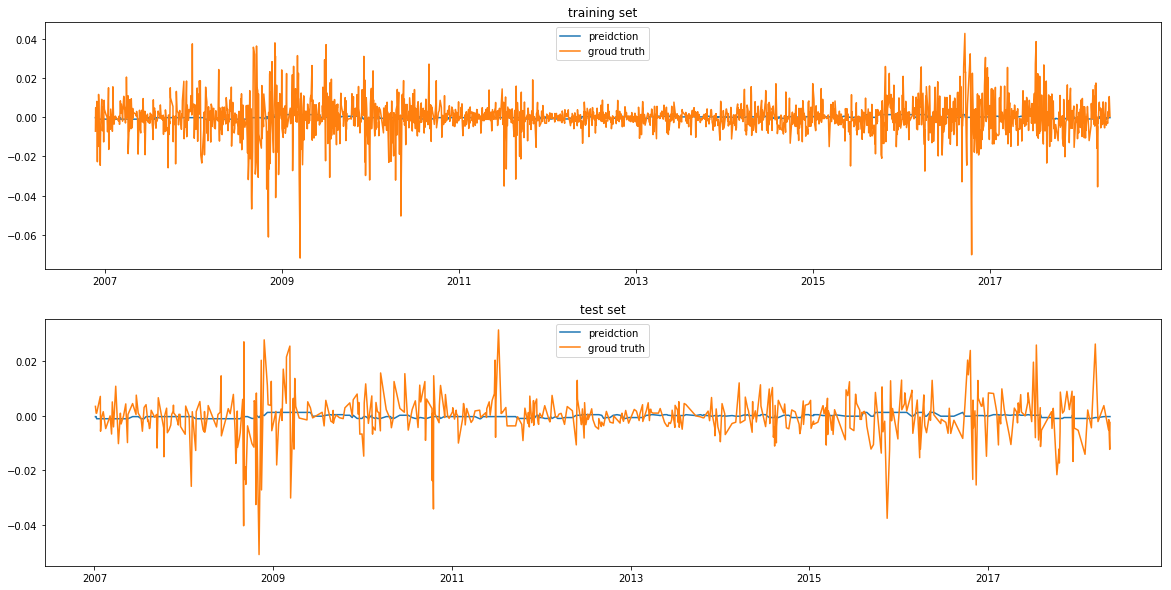

In [426]:
## GPR
def ARD(data,name):
    length = np.ones(len(final_selection[name]['feature']))*1
    kernels = {'RBF+Noise1':1.0 * RBF(length_scale=length)+WhiteKernel(1e-4),\
               'Matern+Noise1':1.0 * Matern(length_scale=length,nu=1.5)+WhiteKernel(1e-4)
               }
    data_ = pd.concat([data['CLOSE'],data[final_selection[name]['feature']]],axis=1)
    gaussian_result = selected_kernel(kernels,data_)
    return gaussian_result

data_set = [cu_lag1,cu_lag5,cu_lag22,al_lag1,al_lag5,al_lag22]
kernels = {
           'RBF+Noise1':1.0 * RBF(length_scale=10.0)+WhiteKernel(1e-4),\
           'RBF+Noise2':1.0 * RBF(length_scale=1.0)+WhiteKernel(1e-4),\
           'RationalQuadratic+Noise1':1.0 * RationalQuadratic(length_scale=1.0, alpha=1.0)+WhiteKernel(1e-4),\
           'Matern+Noise1':1.0 * Matern(length_scale=10.0,nu=1.5)+WhiteKernel(1e-4),\
           'Matern+Noise2':1.0 * Matern(length_scale=1.0,nu=1.5)+WhiteKernel(1e-4),\
          }
# gaussian_result = {'cu lag1':[],'cu lag5':[],'cu lag22':[],\
#                   'al lag1':[],'al lag5':[],'al lag22':[]}
gaussian_result2 = {'cu lag1':[],'cu lag5':[],'cu lag22':[],\
              'al lag1':[],'al lag5':[],'al lag22':[]}
# for i,name in enumerate(gaussian_result.keys()):
#     gaussian_result[name] = selected_kernel(kernels,data_set[i],final_selection[name]['feature'])

for i,name in enumerate(gaussian_result2.keys()):
    gaussian_result2[name] = ARD(data_set[i],name)

In [608]:
gp.kernel_.get_params()

{'k1': 0.0263**2 * RBF(length_scale=[990, 0.0104, 0.00508, 1.6, 0.00251, 20.3, 0.0142, 0.00343]),
 'k1__k1': 0.0263**2,
 'k1__k1__constant_value': 0.0006932270383053027,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2': RBF(length_scale=[990, 0.0104, 0.00508, 1.6, 0.00251, 20.3, 0.0142, 0.00343]),
 'k1__k2__length_scale': array([9.90137969e+02, 1.03813951e-02, 5.07905030e-03, 1.60186606e+00,
        2.51042830e-03, 2.02615244e+01, 1.41924767e-02, 3.42545907e-03]),
 'k1__k2__length_scale_bounds': (1e-05, 100000.0),
 'k2': WhiteKernel(noise_level=4.76e-05),
 'k2__noise_level': 4.762333971690911e-05,
 'k2__noise_level_bounds': (1e-05, 100000.0)}

In [626]:
a = [990, 0.0104, 0.00508, 1.6, 0.00251, 20.3, 0.0142, 0.00343]
b = final_selection['cu lag1']
d = {'feature': b, 'lengthscale': a}
c = pd.DataFrame(data = d)

In [632]:
c.sort_values(by=['lengthscale'],ascending=True)

feature  lengthscale
4     cu_lme_prices_ewma_5-ewma_66_lags1      0.00251
7          shfe_cu1_ewma_5-ewma_22_lags1      0.00343
2      cu_lme_prices_ewma_1-ewma_5_lags1      0.00508
1     cu_lme_prices_ewma_1-ewma_22_lags1      0.01040
6         cu_lme_prices_pct_change_lags1      0.01420
3     cu_lme_prices_ewma_1-ewma_66_lags1      1.60000
5  cu_lme_prices_pct_change_decile_lags1     20.30000
0              bdi_ewma_22-ewma_66_lags1    990.00000

# Feature Selection

# univariate feature selection

In [231]:
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn import feature_selection
from sklearn.feature_selection import SelectPercentile

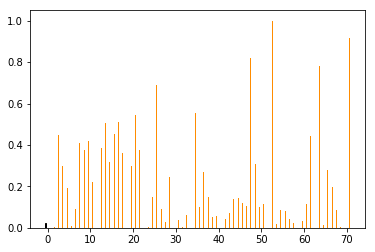

In [411]:
# X_indices = np.arange(X_train.shape[-1])
# selector = SelectPercentile(f_regression, percentile=10)
# selector.fit(X_train, y_train)
# scores = -np.log10(selector.pvalues_)
# scores /= scores.max()
# plt.bar(X_indices - .45, scores, width=.2,
#         label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
#         edgecolor='black')
# plt.show()


# plt.figure(figsize=(50,10))
# for i in range(20,25):
#     plt.subplot(1,25, i + 1)
#     plt.scatter(np.array(X_train)[:, i], y_train, edgecolor='black', s=20)
#     plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
#     if i == 0:
#         plt.ylabel("$y$", fontsize=14)
#     plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
#               fontsize=16)
# plt.show()

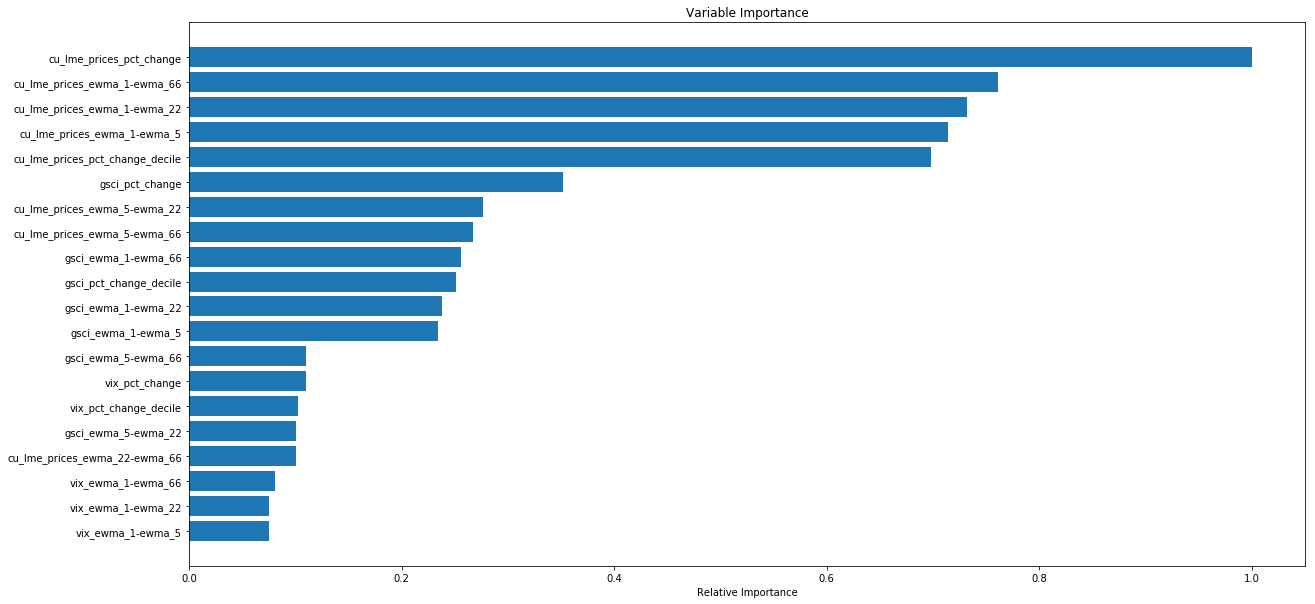

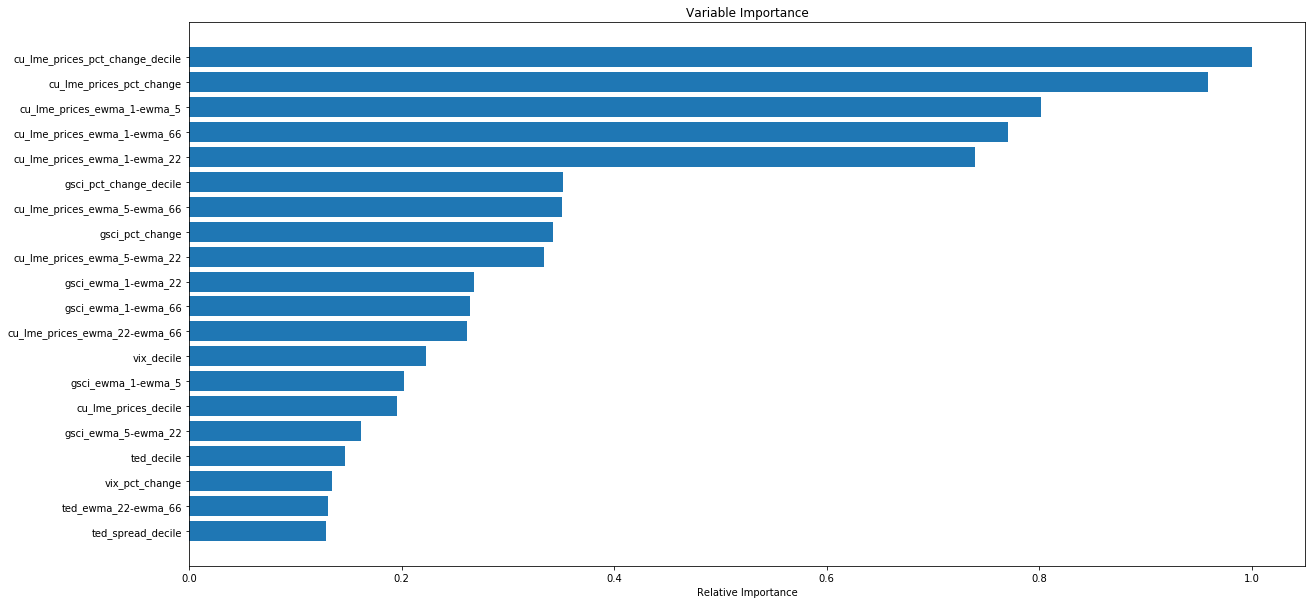

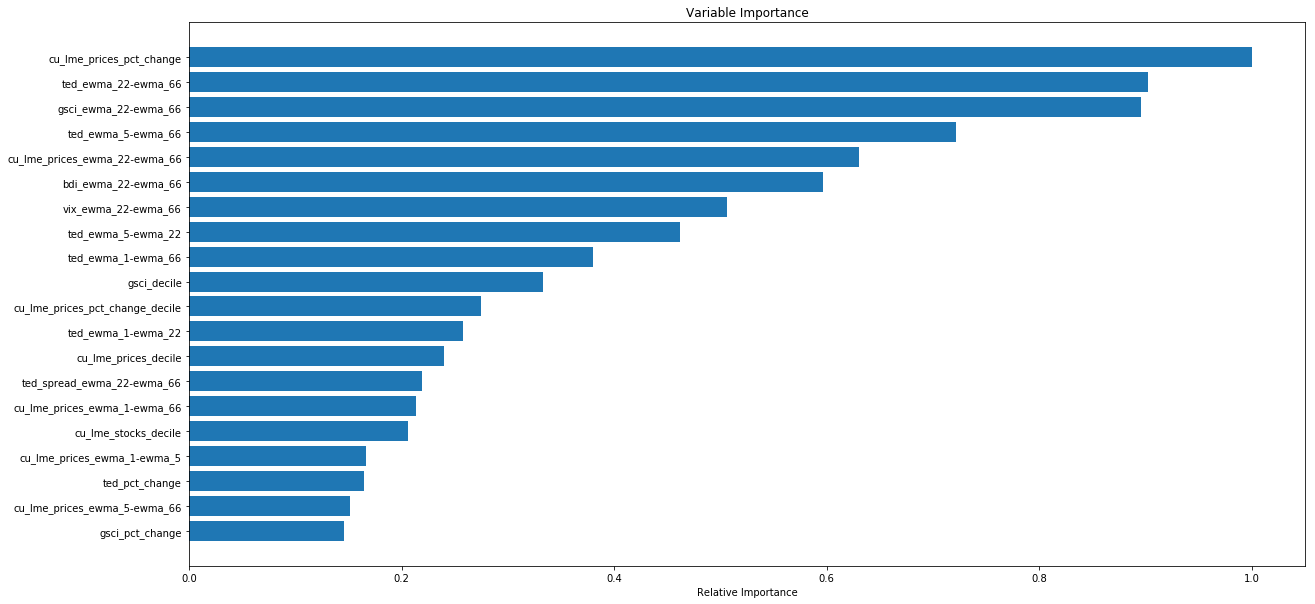

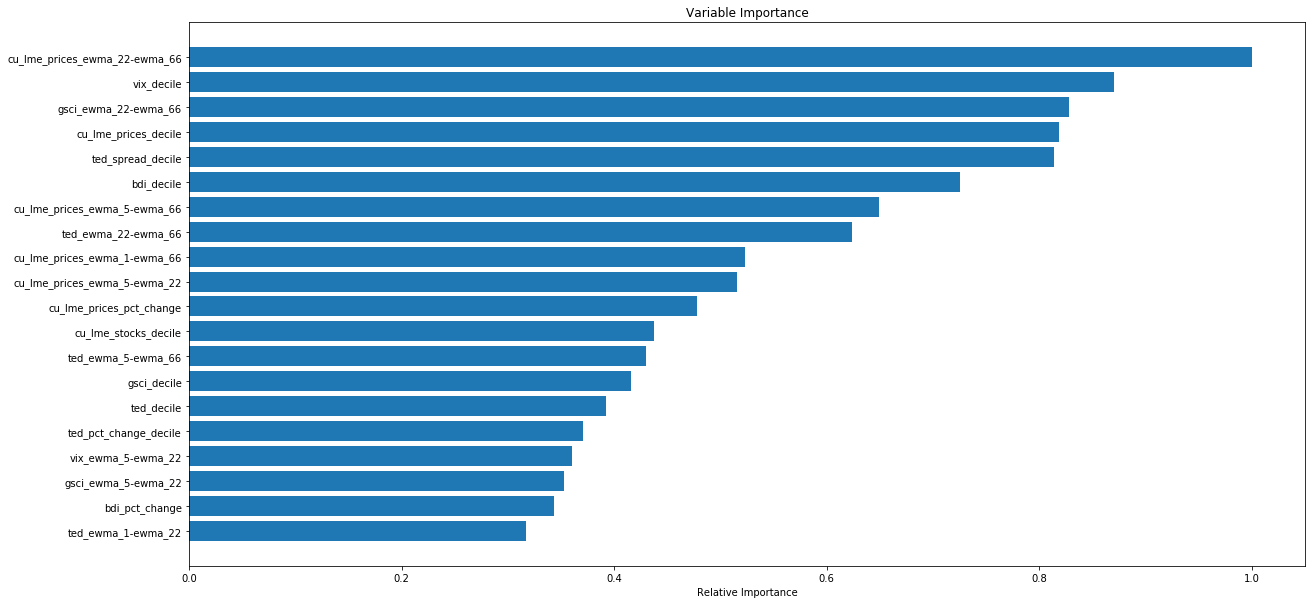

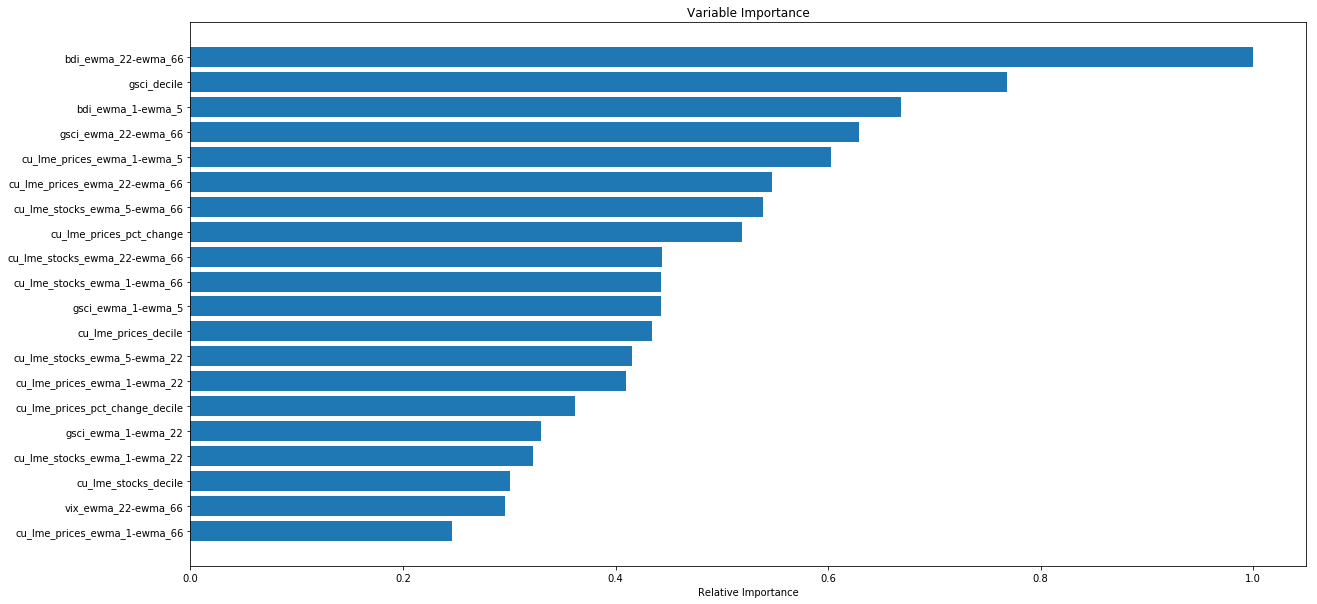

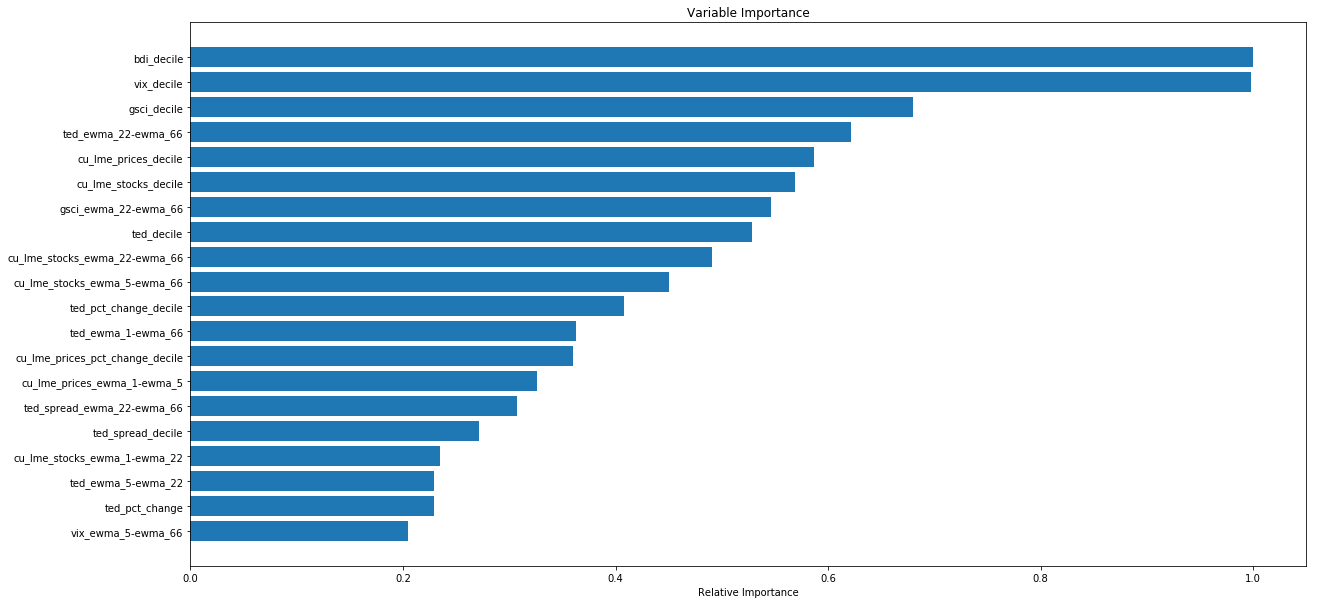

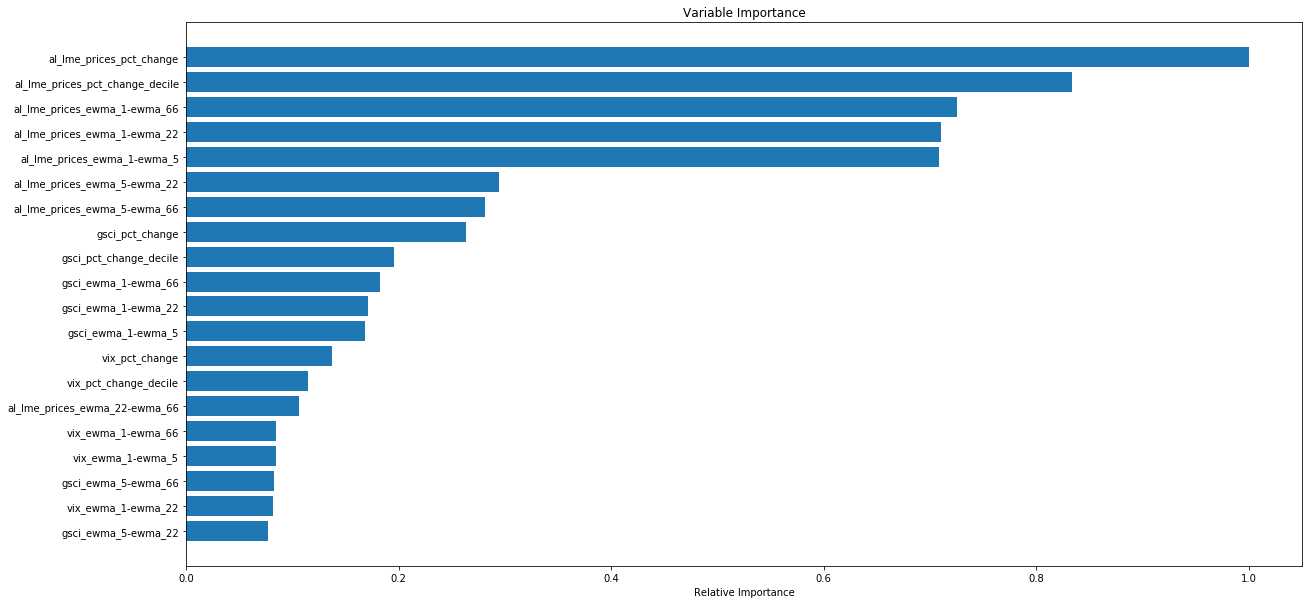

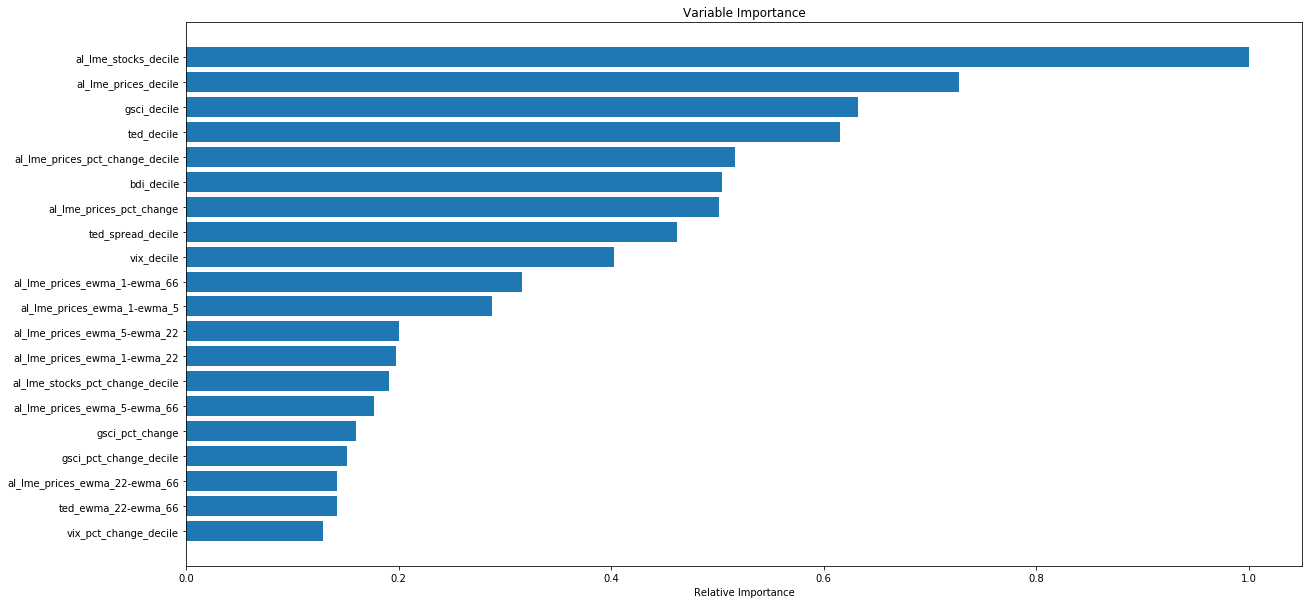

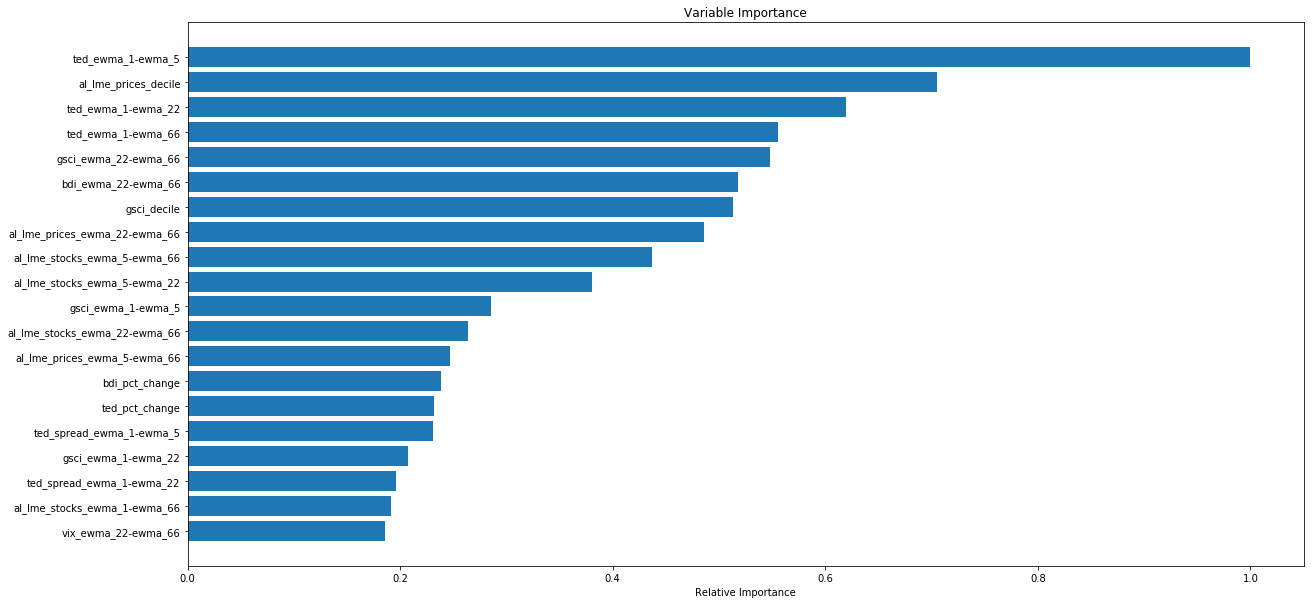

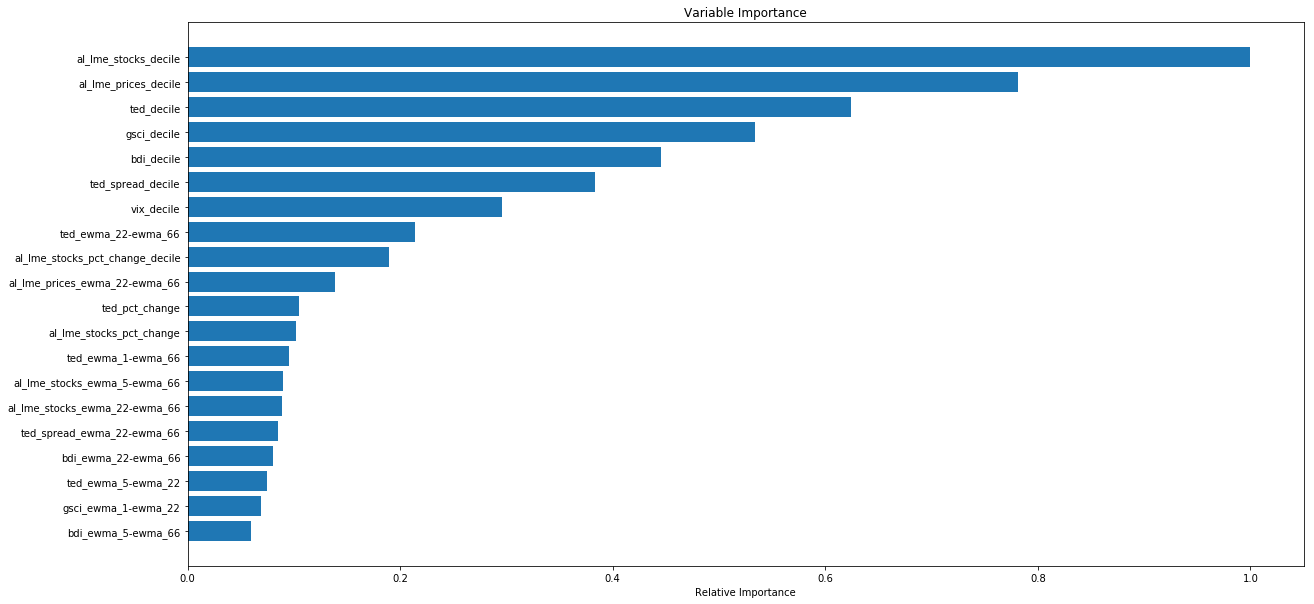

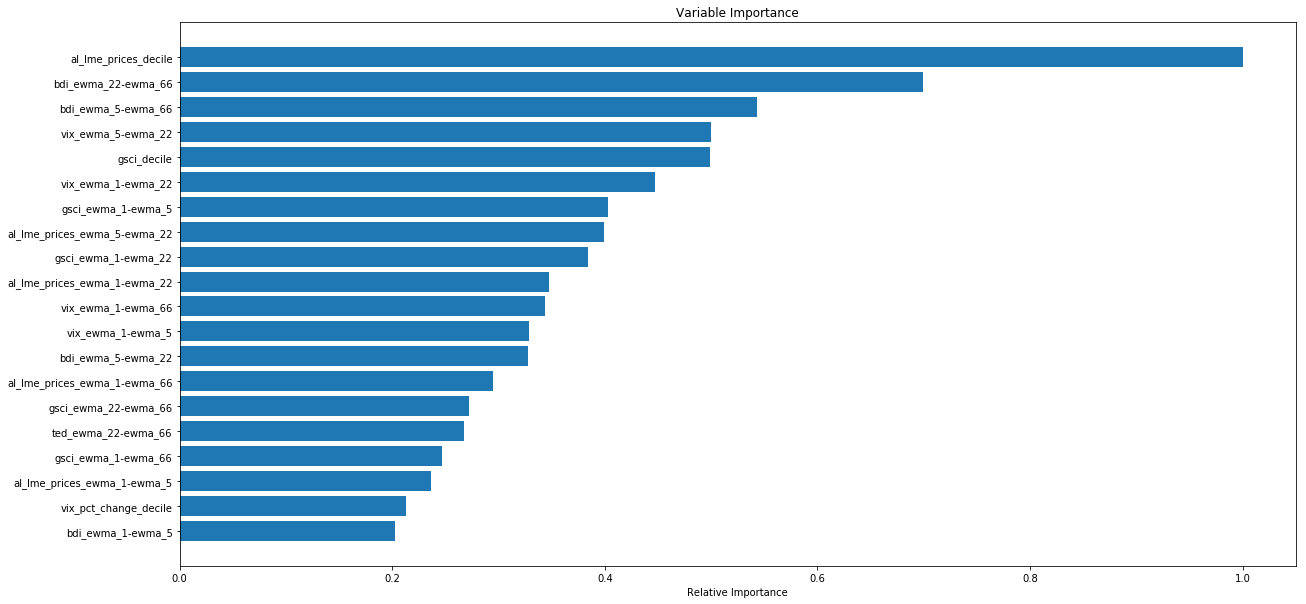

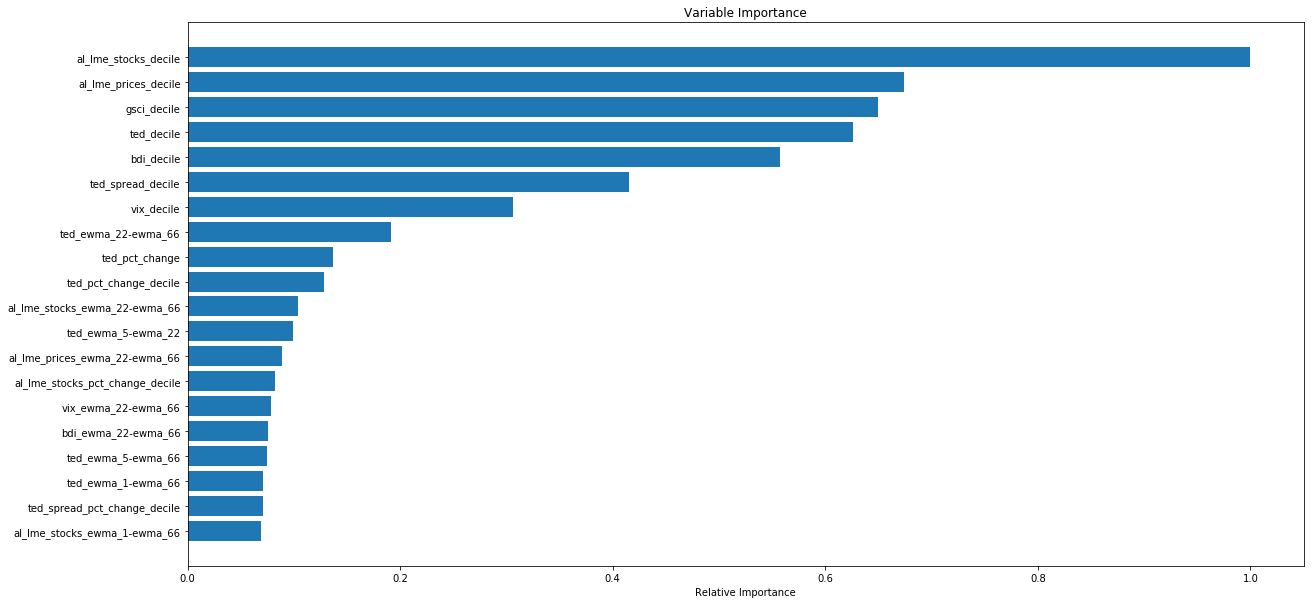

In [232]:
data = {'cu lag1':cu_lag1,'cu lag5':cu_lag5,'cu lag22':cu_lag22,\
        'al lag1':al_lag1,'al lag5':al_lag5,'al lag22':al_lag22}
def uni_selection(data):
    uni_feature = {}
    
    for i in data.keys():
        X_train = data[i].drop(['CLOSE'],axis = 1)
        y_train = data[i]['CLOSE']

        f_test, _ = f_regression(X_train, y_train)
        f_test /= np.max(f_test)

        mi = mutual_info_regression(X_train, y_train)
        mi /= np.max(mi)
        temp = {'f regression':f_test,'mutual info':mi}
        uni_feature[i] = {}
        for t in temp.keys():
            sorted_idx = np.argsort(temp[t])
            pos = np.arange(20) + .5
            fig = plt.figure(figsize=(20,10))
            plt.subplot(1, 1, 1)
            plt.barh(pos, temp[t][sorted_idx][-20:], align='center')
            plt.yticks(pos, X_train.columns[sorted_idx][-20:])
            plt.xlabel('Relative Importance')
            plt.title('Variable Importance')
            plt.show()
            fig.savefig('%s+%s.png'%(i,t))
            uni_feature[i][t] = X_train.columns[sorted_idx]
            uni_feature[i]['value of %s'%t] = temp[t][sorted_idx]
    return uni_feature

uni_selection_result = uni_selection(data)

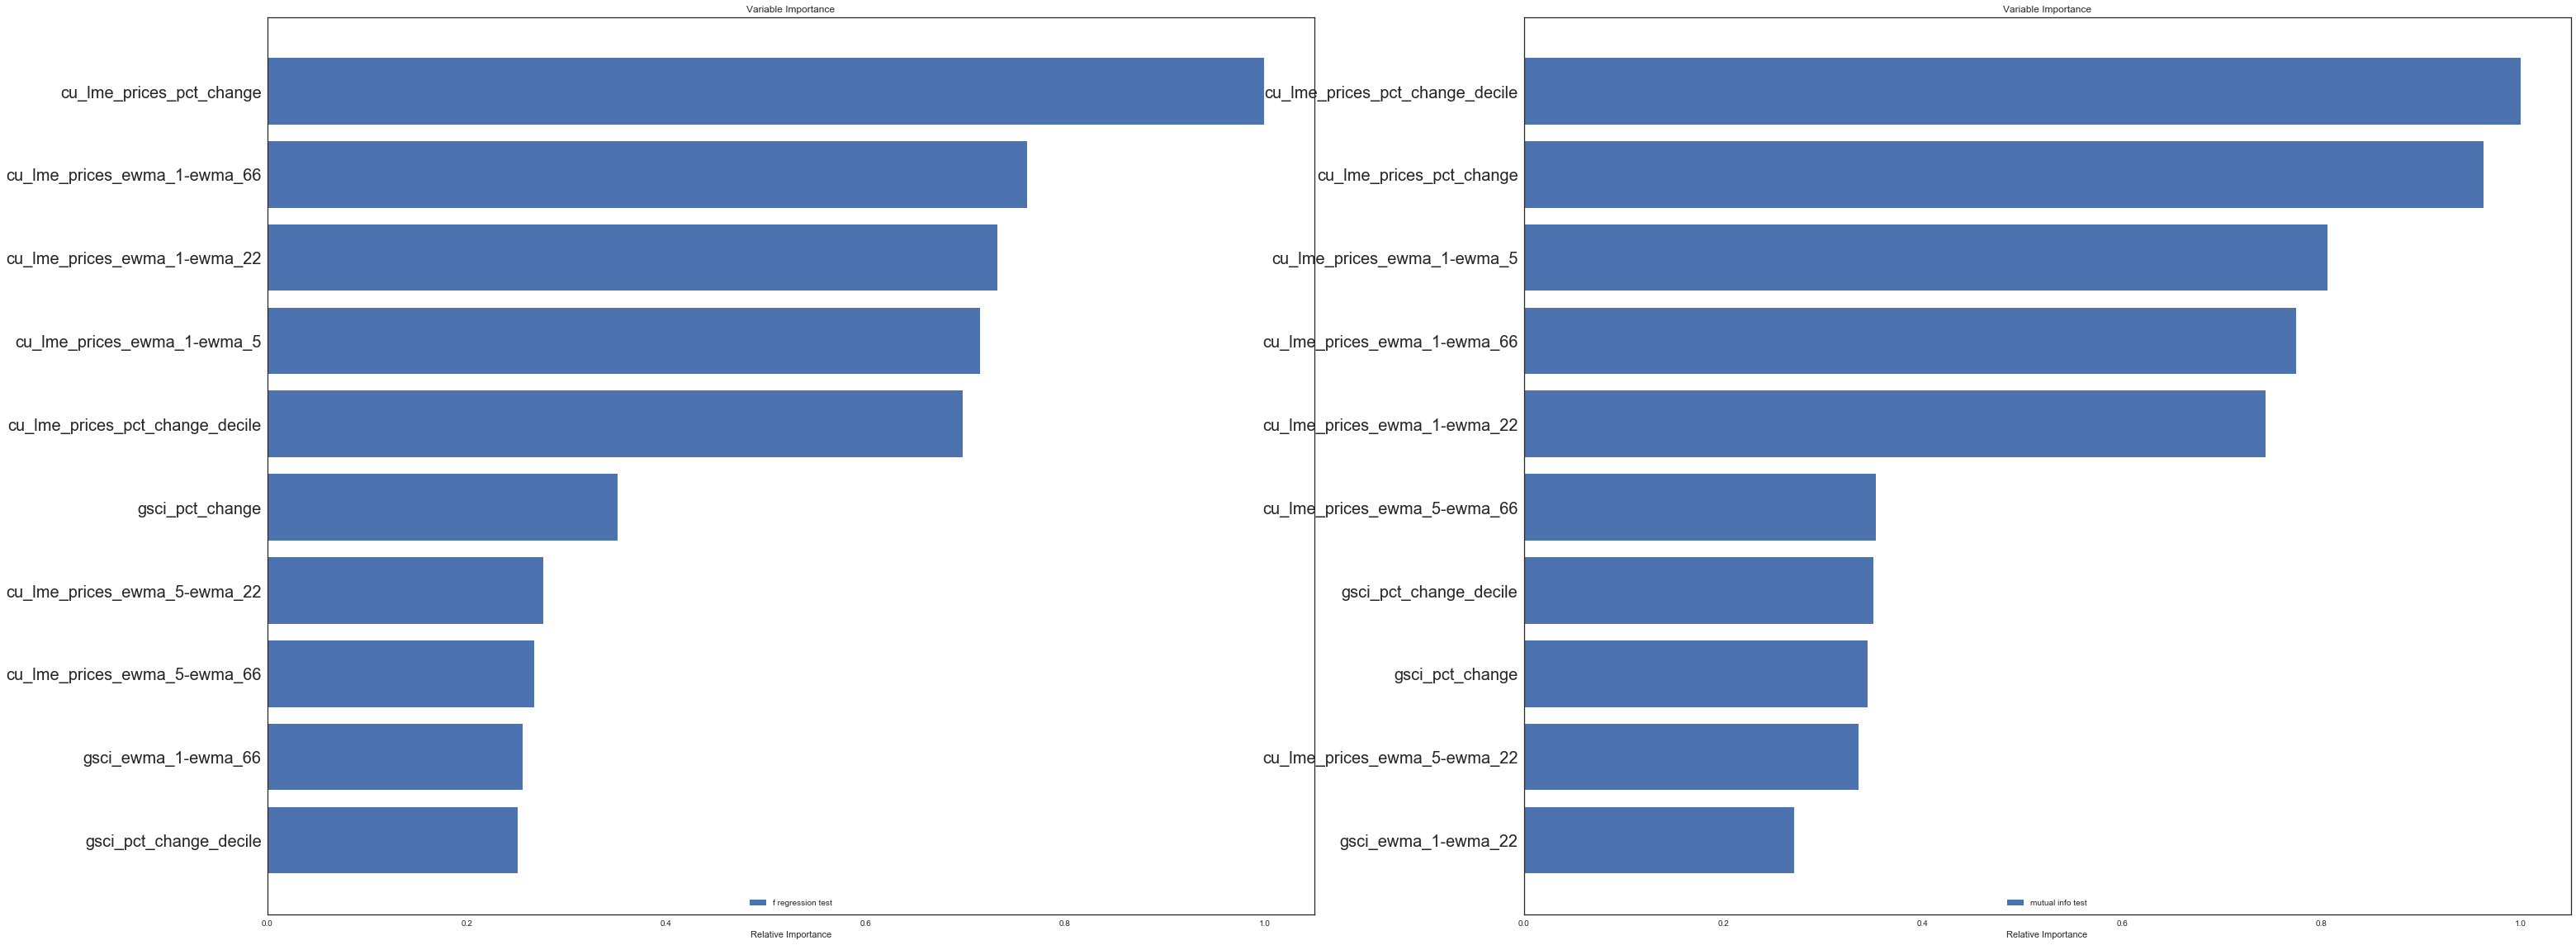

In [930]:
pos = np.arange(10) + .5
fig = plt.figure(figsize=(50,20))
plt.subplot(1, 2, 1)
plt.barh(pos, uni_selection_result['cu lag1']['value of f regression'][-10:], align='center')
plt.yticks(pos,uni_selection_result['cu lag1']['f regression'][-10:],fontsize=20)
plt.legend(['f regression test'],loc = 'lower center')
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.subplot(1, 2, 2)
plt.barh(pos, uni_selection_result['cu lag1']['value of mutual info'][-10:], align='center')
plt.yticks(pos,uni_selection_result['cu lag1']['mutual info'][-10:],fontsize=20)
plt.legend(['mutual info test'],loc = 'lower center')
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
# fig.savefig('cu lag1 uni')

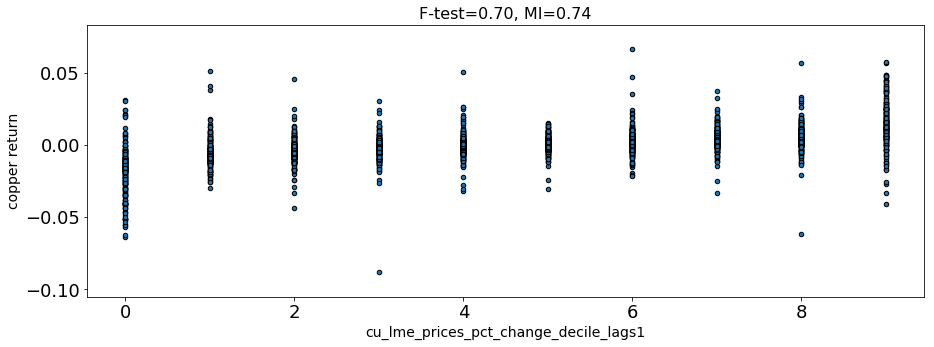

In [227]:
# X_train =  cu_lag1.drop(['CLOSE'],axis=1)
# y_train =  cu_lag1['CLOSE']

# f_test, _ = f_regression(X_train, y_train)
# f_test /= np.max(f_test)

# mi = mutual_info_regression(X_train, y_train)
# mi /= np.max(mi)

fig = plt.figure(figsize=(15, 5))
plt.subplot(1,1,1)
name = uni_selection_result['cu lag1']['f regression'][-5]
plt.scatter(np.array(X_train[name]), y_train, edgecolor='black', s=20)
plt.xlabel("%s"%name, fontsize=14)
plt.ylabel("copper return", fontsize=14)
plt.title("F-test={:.2f}, MI={:.2f}".format(uni_selection_result['cu lag1']['value of f regression'][-5], \
                                           uni_selection_result['cu lag1']['value of mutual info'][-5]),\
          fontsize=16)
plt.show()
# fig.savefig('cu_lme_decile f_m plot')

## multivariate feature selection

## step wise feature selection

In [233]:
from linear_feature_selection import *

/Applications/anaconda3/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [234]:
def stepwise(data):
    
    models_fwd = {}
    models_bwd = {}
    for data in data_set.keys():
        X_train,X_test,y_train,y_test =split_data(data_set[data],0.2)

        models_fwd[data] = pd.DataFrame(columns=["RSS", "model"])
        predictors = []
        for i in range(1,len(X_train.columns)+1):    
            models_fwd[data].loc[i] = forward(predictors,X_train,y_train)
            predictors = models_fwd[data].loc[i]["model"].model.exog_names

        models_bwd[data] = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X_train.columns)))
        predictors = X_train.columns
        while(len(predictors) > 1):  
            models_bwd[data].loc[len(predictors)-1] = backward(predictors,X_train,y_train)
            predictors = models_bwd[data].loc[len(predictors)-1]["model"].model.exog_names
    
    return models_fwd,models_bwd
            

In [237]:
data_set = {'cu lag1':cu_lag1,'cu lag5':cu_lag5,'cu lag22':cu_lag22,\
        'al lag1':al_lag1,'al lag5':al_lag5,'al lag22':al_lag22}
models_fwd,models_bwd = stepwise(data_set)

Processed  63 models on 1 predictors in 0.12392306327819824 seconds.
Processed  62 models on 2 predictors in 0.11593317985534668 seconds.
Processed  61 models on 3 predictors in 0.17797183990478516 seconds.
Processed  60 models on 4 predictors in 0.1136620044708252 seconds.
Processed  59 models on 5 predictors in 0.12254810333251953 seconds.
Processed  58 models on 6 predictors in 0.13353610038757324 seconds.
Processed  57 models on 7 predictors in 0.14898896217346191 seconds.
Processed  56 models on 8 predictors in 0.15261626243591309 seconds.
Processed  55 models on 9 predictors in 0.15036797523498535 seconds.
Processed  54 models on 10 predictors in 0.1552572250366211 seconds.
Processed  53 models on 11 predictors in 0.15601420402526855 seconds.
Processed  52 models on 12 predictors in 0.16500186920166016 seconds.
Processed  51 models on 13 predictors in 0.1672511100769043 seconds.
Processed  50 models on 14 predictors in 0.1619739532470703 seconds.
Processed  49 models on 15 predic

Processed  8 models on 7 predictors in 0.020921945571899414 seconds.
Processed  7 models on 6 predictors in 0.021593093872070312 seconds.
Processed  6 models on 5 predictors in 0.015717744827270508 seconds.
Processed  5 models on 4 predictors in 0.013618946075439453 seconds.
Processed  4 models on 3 predictors in 0.011307001113891602 seconds.
Processed  3 models on 2 predictors in 0.008499860763549805 seconds.
Processed  2 models on 1 predictors in 0.006756305694580078 seconds.
Processed  63 models on 1 predictors in 0.14658713340759277 seconds.
Processed  62 models on 2 predictors in 0.13132309913635254 seconds.
Processed  61 models on 3 predictors in 0.12044525146484375 seconds.
Processed  60 models on 4 predictors in 0.11771178245544434 seconds.
Processed  59 models on 5 predictors in 0.13595104217529297 seconds.
Processed  58 models on 6 predictors in 0.17022490501403809 seconds.
Processed  57 models on 7 predictors in 0.1502530574798584 seconds.
Processed  56 models on 8 predictor

Processed  14 models on 13 predictors in 0.04795098304748535 seconds.
Processed  13 models on 12 predictors in 0.04102492332458496 seconds.
Processed  12 models on 11 predictors in 0.03650999069213867 seconds.
Processed  11 models on 10 predictors in 0.03499484062194824 seconds.
Processed  10 models on 9 predictors in 0.025262117385864258 seconds.
Processed  9 models on 8 predictors in 0.02265310287475586 seconds.
Processed  8 models on 7 predictors in 0.022555112838745117 seconds.
Processed  7 models on 6 predictors in 0.018182992935180664 seconds.
Processed  6 models on 5 predictors in 0.014671802520751953 seconds.
Processed  5 models on 4 predictors in 0.013587236404418945 seconds.
Processed  4 models on 3 predictors in 0.011013984680175781 seconds.
Processed  3 models on 2 predictors in 0.007502079010009766 seconds.
Processed  2 models on 1 predictors in 0.0058460235595703125 seconds.
Processed  63 models on 1 predictors in 0.1296839714050293 seconds.
Processed  62 models on 2 pred

Processed  20 models on 19 predictors in 0.07966113090515137 seconds.
Processed  19 models on 18 predictors in 0.08219480514526367 seconds.
Processed  18 models on 17 predictors in 0.06584978103637695 seconds.
Processed  17 models on 16 predictors in 0.10396385192871094 seconds.
Processed  16 models on 15 predictors in 0.06835818290710449 seconds.
Processed  15 models on 14 predictors in 0.08261775970458984 seconds.
Processed  14 models on 13 predictors in 0.08207511901855469 seconds.
Processed  13 models on 12 predictors in 0.05466413497924805 seconds.
Processed  12 models on 11 predictors in 0.062387943267822266 seconds.
Processed  11 models on 10 predictors in 0.0546412467956543 seconds.
Processed  10 models on 9 predictors in 0.07353711128234863 seconds.
Processed  9 models on 8 predictors in 0.035091400146484375 seconds.
Processed  8 models on 7 predictors in 0.05200314521789551 seconds.
Processed  7 models on 6 predictors in 0.01974201202392578 seconds.
Processed  6 models on 5 p

Processed  26 models on 25 predictors in 0.15072202682495117 seconds.
Processed  25 models on 24 predictors in 0.1333158016204834 seconds.
Processed  24 models on 23 predictors in 0.12301993370056152 seconds.
Processed  23 models on 22 predictors in 0.1256709098815918 seconds.
Processed  22 models on 21 predictors in 0.10059404373168945 seconds.
Processed  21 models on 20 predictors in 0.10609912872314453 seconds.
Processed  20 models on 19 predictors in 0.0826408863067627 seconds.
Processed  19 models on 18 predictors in 0.0804738998413086 seconds.
Processed  18 models on 17 predictors in 0.06943202018737793 seconds.
Processed  17 models on 16 predictors in 0.06823992729187012 seconds.
Processed  16 models on 15 predictors in 0.05716991424560547 seconds.
Processed  15 models on 14 predictors in 0.052462100982666016 seconds.
Processed  14 models on 13 predictors in 0.05209708213806152 seconds.
Processed  13 models on 12 predictors in 0.042675018310546875 seconds.
Processed  12 models o

Processed  32 models on 31 predictors in 0.22965240478515625 seconds.
Processed  31 models on 30 predictors in 0.2126326560974121 seconds.
Processed  30 models on 29 predictors in 0.20019102096557617 seconds.
Processed  29 models on 28 predictors in 0.1835477352142334 seconds.
Processed  28 models on 27 predictors in 0.1608271598815918 seconds.
Processed  27 models on 26 predictors in 0.15021491050720215 seconds.
Processed  26 models on 25 predictors in 0.13247895240783691 seconds.
Processed  25 models on 24 predictors in 0.12125396728515625 seconds.
Processed  24 models on 23 predictors in 0.10870003700256348 seconds.
Processed  23 models on 22 predictors in 0.09678411483764648 seconds.
Processed  22 models on 21 predictors in 0.09426188468933105 seconds.
Processed  21 models on 20 predictors in 0.08155298233032227 seconds.
Processed  20 models on 19 predictors in 0.08024287223815918 seconds.
Processed  19 models on 18 predictors in 0.07173490524291992 seconds.
Processed  18 models on

Processed  38 models on 37 predictors in 0.3749732971191406 seconds.
Processed  37 models on 36 predictors in 0.3237419128417969 seconds.
Processed  36 models on 35 predictors in 0.3156700134277344 seconds.
Processed  35 models on 34 predictors in 0.28572511672973633 seconds.
Processed  34 models on 33 predictors in 0.26563000679016113 seconds.
Processed  33 models on 32 predictors in 0.2492380142211914 seconds.
Processed  32 models on 31 predictors in 0.23201799392700195 seconds.
Processed  31 models on 30 predictors in 0.21373796463012695 seconds.
Processed  30 models on 29 predictors in 0.19203686714172363 seconds.
Processed  29 models on 28 predictors in 0.18146109580993652 seconds.
Processed  28 models on 27 predictors in 0.16580986976623535 seconds.
Processed  27 models on 26 predictors in 0.15158915519714355 seconds.
Processed  26 models on 25 predictors in 0.13723278045654297 seconds.
Processed  25 models on 24 predictors in 0.12299299240112305 seconds.
Processed  24 models on 

In [247]:
## forward stepwise
# models_fwd = pd.DataFrame(columns=["RSS", "model"])
# tic = time.time()
# predictors = []
# for i in range(1,len(X_train.columns)+1):    
#     models_fwd.loc[i] = forward(predictors,X_train,y_train)
#     predictors = models_fwd.loc[i]["model"].model.exog_names
# toc = time.time()
# print("Total elapsed time:", (toc-tic), "seconds.")

## backward stepwise
# models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X_train.columns)))
# tic = time.time()
# predictors = X_train.columns
# while(len(predictors) > 1):  
#     models_bwd.loc[len(predictors)-1] = backward(predictors,X_train,y_train)
#     predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names
# toc = time.time()
# print("Total elapsed time:", (toc-tic), "seconds.")

In [241]:
def plot_linear_result(model,model_b,X_test,y_test,data_name):
    color1 ='orange'
    color2 ='blue'
    best = {'AIC_number':[],'BIC_number':[],'parameter_aic':[],'parameter_bic':[]}
    best['AIC_number'] = np.argmin(model.apply(lambda row: row[1].aic, axis=1))
    best['BIC_number'] = np.argmin(model.apply(lambda row: row[1].bic, axis=1))

    best['parameter_aic'] = [para for para,_ in model.loc[best['AIC_number'],"model"].params.iteritems()]
    best['parameter_bic'] = [para for para,_ in model.loc[best['BIC_number'],"model"].params.iteritems()]
    
    y_pre_aic = model.loc[best['AIC_number'],'model'].predict(X_test[best['parameter_aic']])
    y_pre_bic = model.loc[best['BIC_number'],'model'].predict(X_test[best['parameter_bic']])
    y_pre_aic = pd.Series(data = y_pre_aic,index = y_test.index)
    y_pre_bic = pd.Series(data = y_pre_bic,index = y_test.index)
    corr_train_aic,mse_train_aic = criteria(y_test,y_pre_aic)
    corr_train_bic,mse_train_bic = criteria(y_test,y_pre_bic)
    
    best_b = {'AIC_number':[],'BIC_number':[],'parameter_aic':[],'parameter_bic':[]}
    best_b['AIC_number'] = np.argmin(model_b.apply(lambda row: row[1].aic, axis=1))
    best_b['BIC_number'] = np.argmin(model_b.apply(lambda row: row[1].bic, axis=1))

    best_b['parameter_aic'] = [para for para,_ in model_b.loc[best_b['AIC_number'],"model"].params.iteritems()]
    best_b['parameter_bic'] = [para for para,_ in model_b.loc[best_b['BIC_number'],"model"].params.iteritems()]
    
    y_pre_aic_b = model_b.loc[best_b['AIC_number'],'model'].predict(X_test[best_b['parameter_aic']])
    y_pre_bic_b = model_b.loc[best_b['BIC_number'],'model'].predict(X_test[best_b['parameter_bic']])
    y_pre_aic_b = pd.Series(data = y_pre_aic_b,index = y_test.index)
    y_pre_bic_b = pd.Series(data = y_pre_bic_b,index = y_test.index)
    corr_train_aic_b,mse_train_aic_b = criteria(y_test,y_pre_aic_b)
    corr_train_bic_b,mse_train_bic_b = criteria(y_test,y_pre_bic_b)
    
    
    fig = plt.figure(figsize=(25,10))
    plt.subplot(2,2,1)
    plt.plot(y_pre_aic.sort_index(ascending=True),color = color2)
    plt.plot(y_test.sort_index(ascending=True),color = color1)
    plt.legend(['prediciton of AIC','ground truth'],loc = 'upper center')
    
    plt.title("Forward:correlation={:.6f}, mse={:.6f}".format(corr_train_aic,mse_train_aic,fontsize=10))
    plt.subplot(2,2,2)
    plt.plot(y_pre_bic.sort_index(ascending=True),color = color2)
    plt.plot(y_test.sort_index(ascending=True),color = color1)
    plt.legend(['prediciton of BIC','ground truth'],loc = 'upper center')
    plt.title("Forward:correlation={:.6f}, mse={:.6f}".format(corr_train_bic,mse_train_bic,fontsize=10))

    
    plt.subplot(2,2,3)
    plt.plot(y_pre_aic_b.sort_index(ascending=True),color = color2)
    plt.plot(y_test.sort_index(ascending=True),color=color1)
    plt.legend(['prediciton of AIC','ground truth'],loc = 'upper center')
    
    plt.title("Backward:correlation={:.6f}, mse={:.6f}".format(corr_train_aic_b,mse_train_aic_b,fontsize=10))
    plt.subplot(2,2,4)
    plt.plot(y_pre_bic_b.sort_index(ascending=True),color = color2)
    plt.plot(y_test.sort_index(ascending=True),color = color1)
    plt.legend(['prediciton of BIC','ground truth'],loc = 'upper center')
    plt.title("Backward:correlation={:.6f}, mse={:.6f}".format(corr_train_bic_b,mse_train_bic_b,fontsize=10))
    
    fig.savefig('%s+linear_result.png'%data_name)
    plt.show()
    return best,best_b

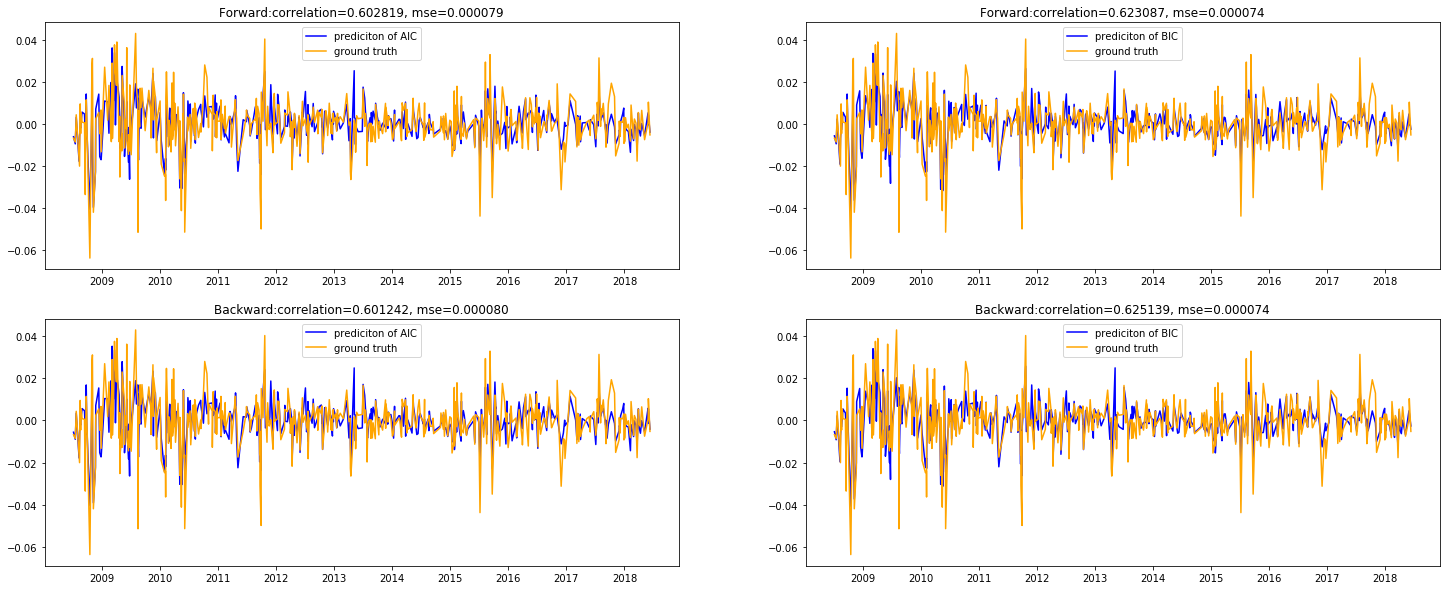

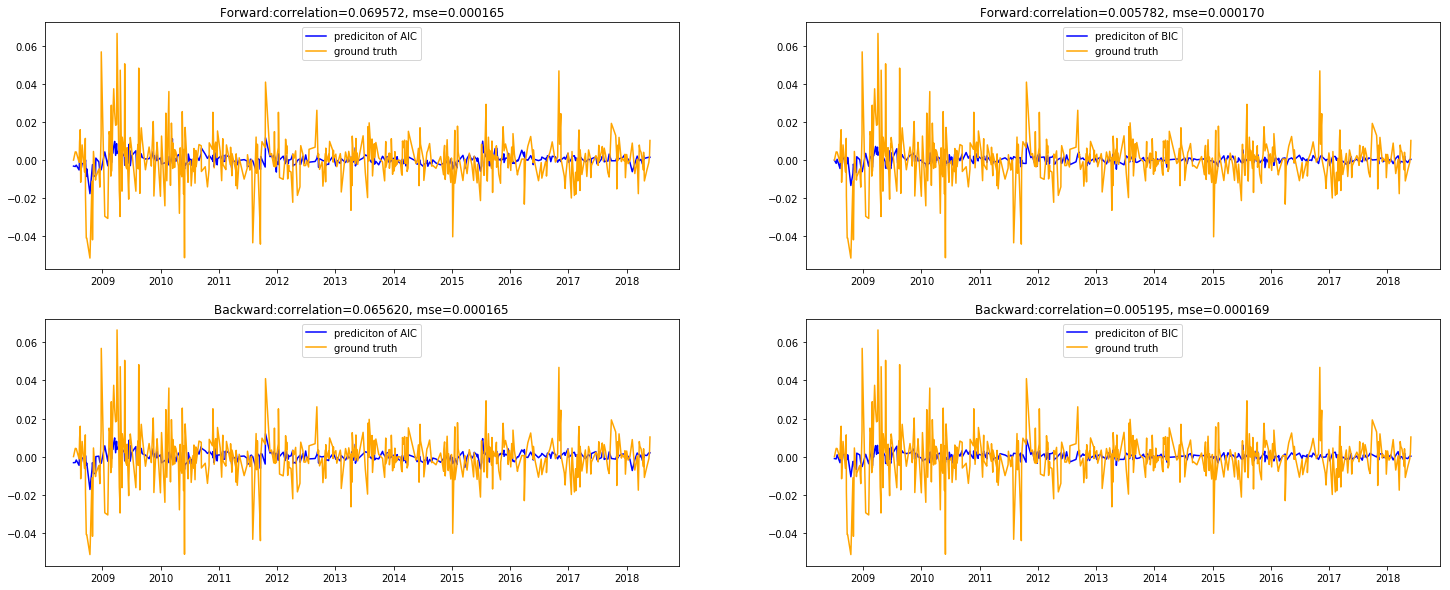

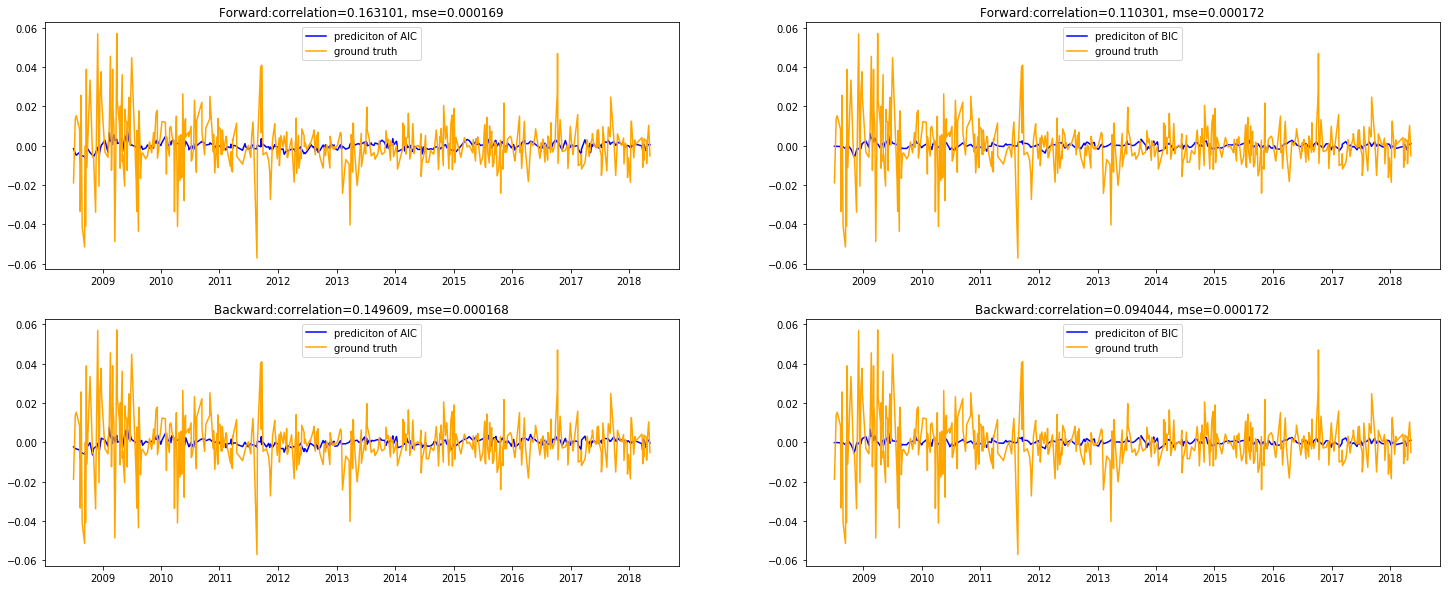

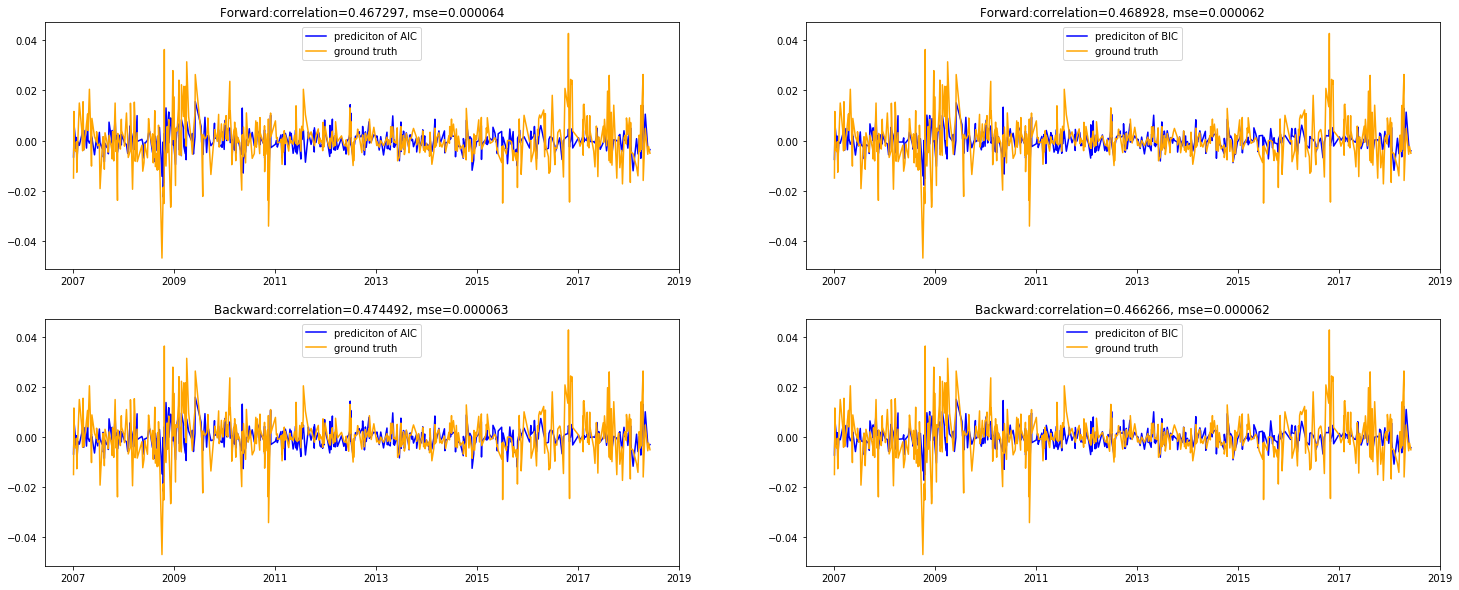

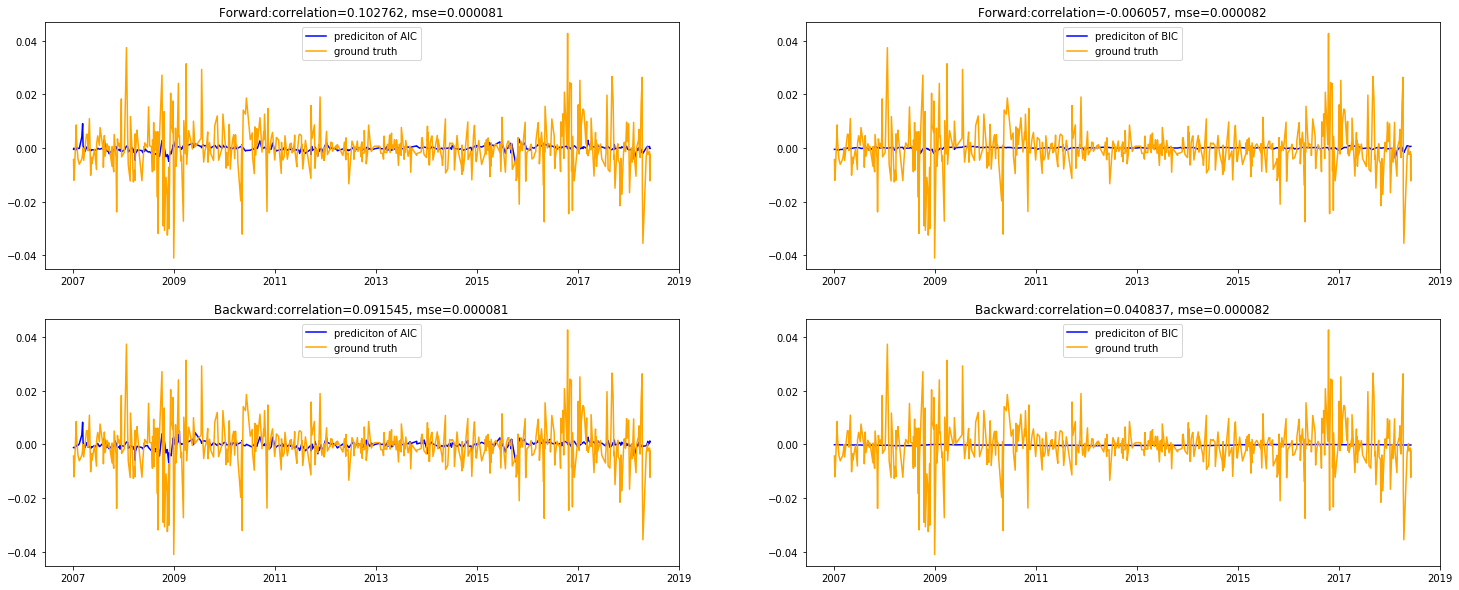

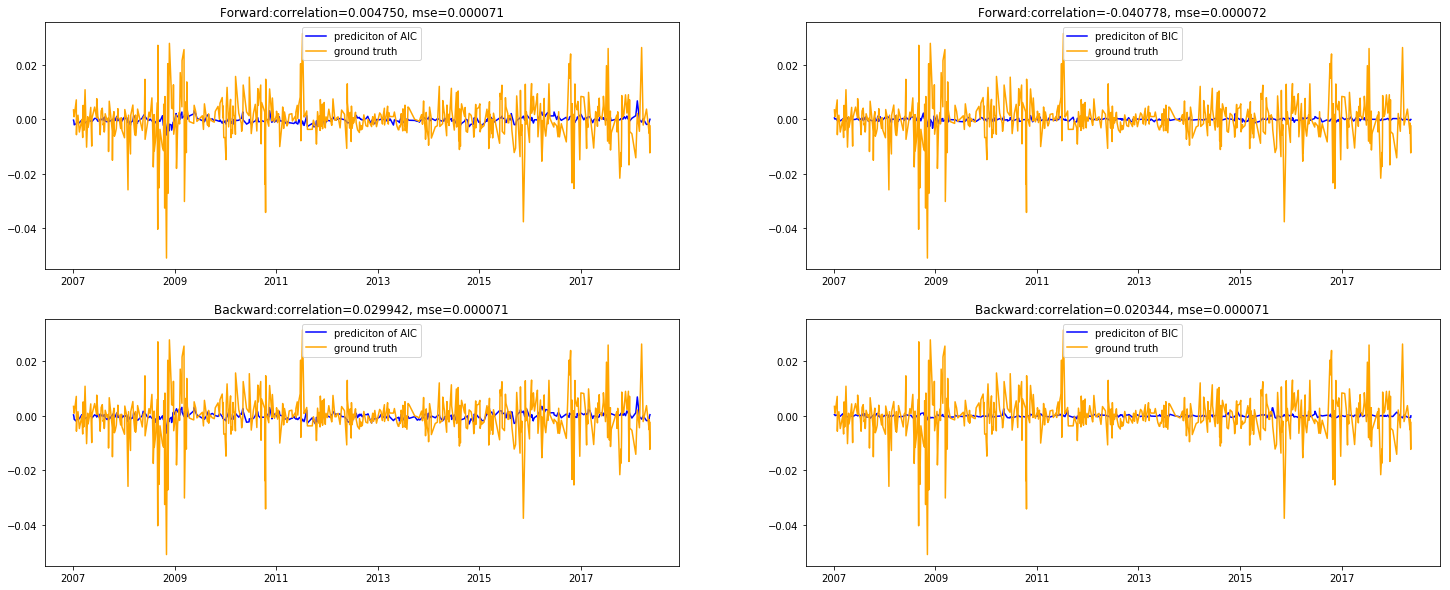

In [242]:
forward_result = {'cu lag1':[],'cu lag5':[], 'cu lag22':[], 'al lag1':[],\
                 'al lag5':[], 'al lag22':[]}
backward_result = {'cu lag1':[],'cu lag5':[], 'cu lag22':[], 'al lag1':[],\
                 'al lag5':[], 'al lag22':[]}
for data in data_set.keys():
    temp = data_set[data]
    X_train,X_test,y_train,y_test =split_data(temp,0.2)
    forward_result[data],backward_result[data] = plot_linear_result(models_fwd[data],models_bwd[data],X_test,y_test,data)

## gradient boosting regression tree


$F_{0}(x) = \bar{y}$

For m = 1 to M do:

$\quad \tilde{y_{i}} = y_{i} - F_{m-1}(x_{i})$,i =1,N
  
$\quad (\rho{m},a_{m}) = argmin_{a,\rho}\sum_{i=1}^{N}[\tilde{y_{i}}-\rho h(x_{i};a)]^{2}$
  
$\quad F_{m}(x) = F_{m-1}(x) + \rho_{m}h(x;a_{m})$
  
endFor

end Algorithm

In [244]:
from sklearn.model_selection import GridSearchCV

In [245]:
## with 63 parameter
def gradient_boosting(data,data_name):
    X_train,X_test,y_train,y_test = split_data(data,0.2)
    max_depth = np.arange(1,10,2)
    max_features = np.arange(1,10,2)
    params = {'n_estimators':[100,500,1000],'max_depth':max_depth,'learning_rate':[0.1,0.01,0.05,0.0001,0.0005], 'loss': ['ls'],\
             'max_features':max_features}

    clf = GridSearchCV(ensemble.GradientBoostingRegressor(), params, cv=5,
                       scoring='neg_mean_squared_error')
    clf.fit(X_train, y_train)

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.6f (+/-%0.06f) for %r"
              % (mean, std * 2, params))

    best_para = clf.cv_results_['params'][-1]
    model = ensemble.GradientBoostingRegressor(**best_para)
    model.fit(X_train,y_train)

    test_score = np.zeros((best_para['n_estimators']), dtype=np.float64)
    for i, y_pred in enumerate(model.staged_predict(X_test)):
        test_score[i] = model.loss_(y_test, y_pred)

    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(best_para['n_estimators']) + 1, model.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(best_para['n_estimators']) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')
    fig.savefig('%s_boosting_result.png'%data_name)
    return model

-0.000134 (+/-0.000034) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 100}
-0.000123 (+/-0.000031) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 500}
-0.000125 (+/-0.000044) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 1000}
-0.000117 (+/-0.000024) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 100}
-0.000122 (+/-0.000047) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 500}
-0.000129 (+/-0.000067) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 1000}
-0.000115 (+/-0.000026) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 5, 'n_estimators': 100}
-0.000125 (+/-0.000055) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 5, 'n_estimators': 500}
-0.000129 (+/-0.000068) for {'

-0.000166 (+/-0.000033) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 100}
-0.000171 (+/-0.000034) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 500}
-0.000179 (+/-0.000041) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 1000}
-0.000168 (+/-0.000035) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 100}
-0.000175 (+/-0.000037) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 500}
-0.000180 (+/-0.000042) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 1000}
-0.000169 (+/-0.000034) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 5, 'n_estimators': 100}
-0.000174 (+/-0.000038) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 5, 'n_estimators': 500}
-0.000180 (+/-0.000038) for {'

-0.000166 (+/-0.000070) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 100}
-0.000170 (+/-0.000068) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 500}
-0.000177 (+/-0.000067) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 1000}
-0.000166 (+/-0.000071) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 100}
-0.000173 (+/-0.000068) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 500}
-0.000179 (+/-0.000067) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 1000}
-0.000167 (+/-0.000070) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 5, 'n_estimators': 100}
-0.000173 (+/-0.000069) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 5, 'n_estimators': 500}
-0.000180 (+/-0.000069) for {'

-0.000067 (+/-0.000013) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 100}
-0.000066 (+/-0.000016) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 500}
-0.000069 (+/-0.000018) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 1000}
-0.000066 (+/-0.000012) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 100}
-0.000068 (+/-0.000016) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 500}
-0.000070 (+/-0.000017) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 1000}
-0.000065 (+/-0.000012) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 5, 'n_estimators': 100}
-0.000069 (+/-0.000017) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 5, 'n_estimators': 500}
-0.000070 (+/-0.000018) for {'

-0.000075 (+/-0.000019) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 100}
-0.000079 (+/-0.000014) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 500}
-0.000080 (+/-0.000013) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 1000}
-0.000076 (+/-0.000017) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 100}
-0.000079 (+/-0.000010) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 500}
-0.000081 (+/-0.000009) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 1000}
-0.000077 (+/-0.000017) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 5, 'n_estimators': 100}
-0.000079 (+/-0.000011) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 5, 'n_estimators': 500}
-0.000082 (+/-0.000009) for {'

-0.000079 (+/-0.000022) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 100}
-0.000081 (+/-0.000023) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 500}
-0.000082 (+/-0.000024) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 1, 'n_estimators': 1000}
-0.000079 (+/-0.000022) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 100}
-0.000082 (+/-0.000022) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 500}
-0.000084 (+/-0.000024) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 3, 'n_estimators': 1000}
-0.000079 (+/-0.000022) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 5, 'n_estimators': 100}
-0.000082 (+/-0.000023) for {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'max_features': 5, 'n_estimators': 500}
-0.000084 (+/-0.000024) for {'

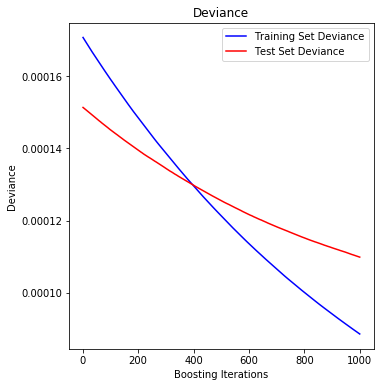

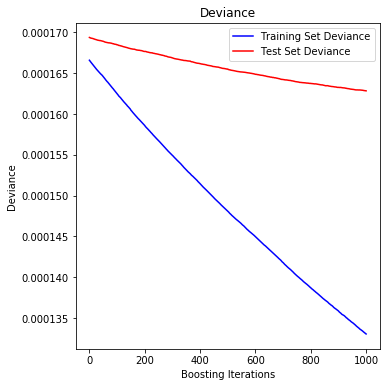

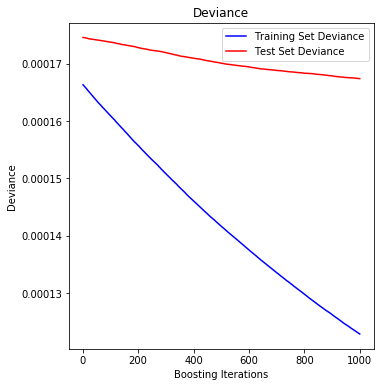

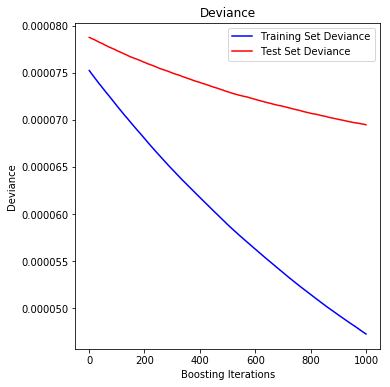

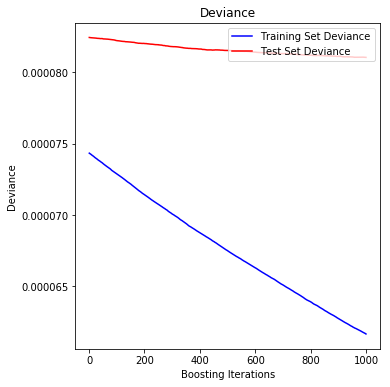

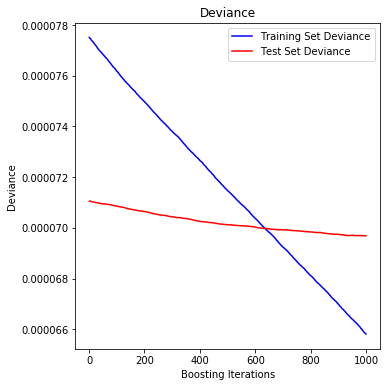

In [247]:
boosting_model_cu_lag1 = gradient_boosting(cu_lag1,'cu lag1')
boosting_model_cu_lag5 = gradient_boosting(cu_lag5,'cu lag5')
boosting_model_cu_lag22 = gradient_boosting(cu_lag22,'cu lag22')

boosting_model_al_lag1 = gradient_boosting(al_lag1,'al lag1')
boosting_model_al_lag5 = gradient_boosting(al_lag5,'al lag5')
boosting_model_al_lag22 = gradient_boosting(al_lag22,'al lag22')

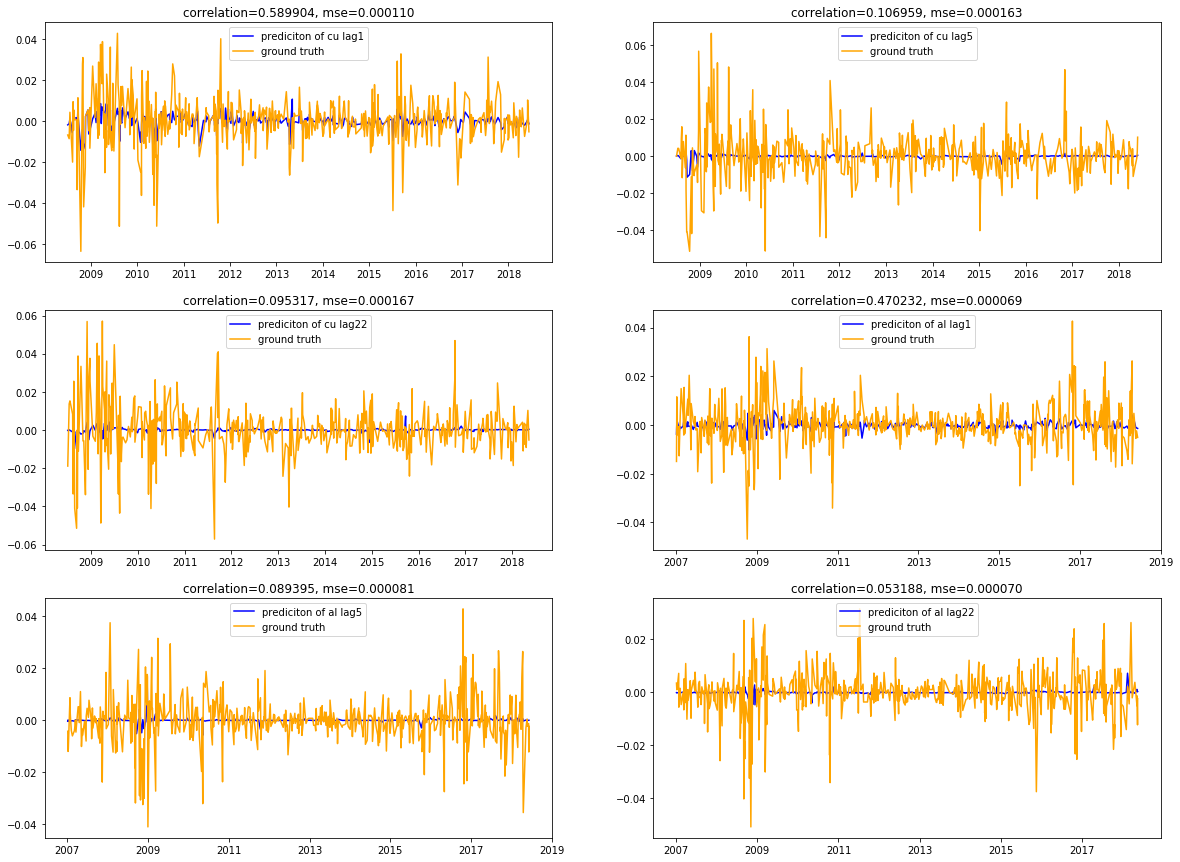

In [251]:
data_set_boosting = {'cu lag1':[cu_lag1,boosting_model_cu_lag1],\
                   'cu lag5':[cu_lag5,boosting_model_cu_lag5],\
                   'cu lag22':[cu_lag22,boosting_model_cu_lag22],\
                   'al lag1':[al_lag1,boosting_model_al_lag1],\
                   'al lag5':[al_lag5,boosting_model_al_lag5],\
                   'al lag22':[al_lag22,boosting_model_al_lag22]}
def plot_boosting(data_set_boosting):
    fig = plt.figure(figsize=(20,15))
    color1 = 'orange'
    color2 = 'blue'
    for i,data in enumerate(data_set_boosting.keys()):
        Data = data_set_boosting[data][0]
        X_train,X_test,y_train,y_test = split_data(Data,0.2)
        model = data_set_boosting[data][1]
        y_pre = model.predict(X_test)
        y_pre = pd.Series(data = y_pre,index = y_test.index)
        corr,mse = criteria(y_test,y_pre)
        plt.subplot(3,2,i+1)
        plt.plot(y_pre.sort_index(ascending=True),color = color2)
        plt.plot(y_test.sort_index(ascending=True),color = color1)
        plt.legend(['prediciton of %s'%data,'ground truth'],loc = 'upper center')
        plt.title("correlation={:.6f}, mse={:.6f}".format(corr,mse,fontsize=10))
    plt.show()
    fig.savefig('boosting_result.png')
    
plot_boosting(data_set_boosting)

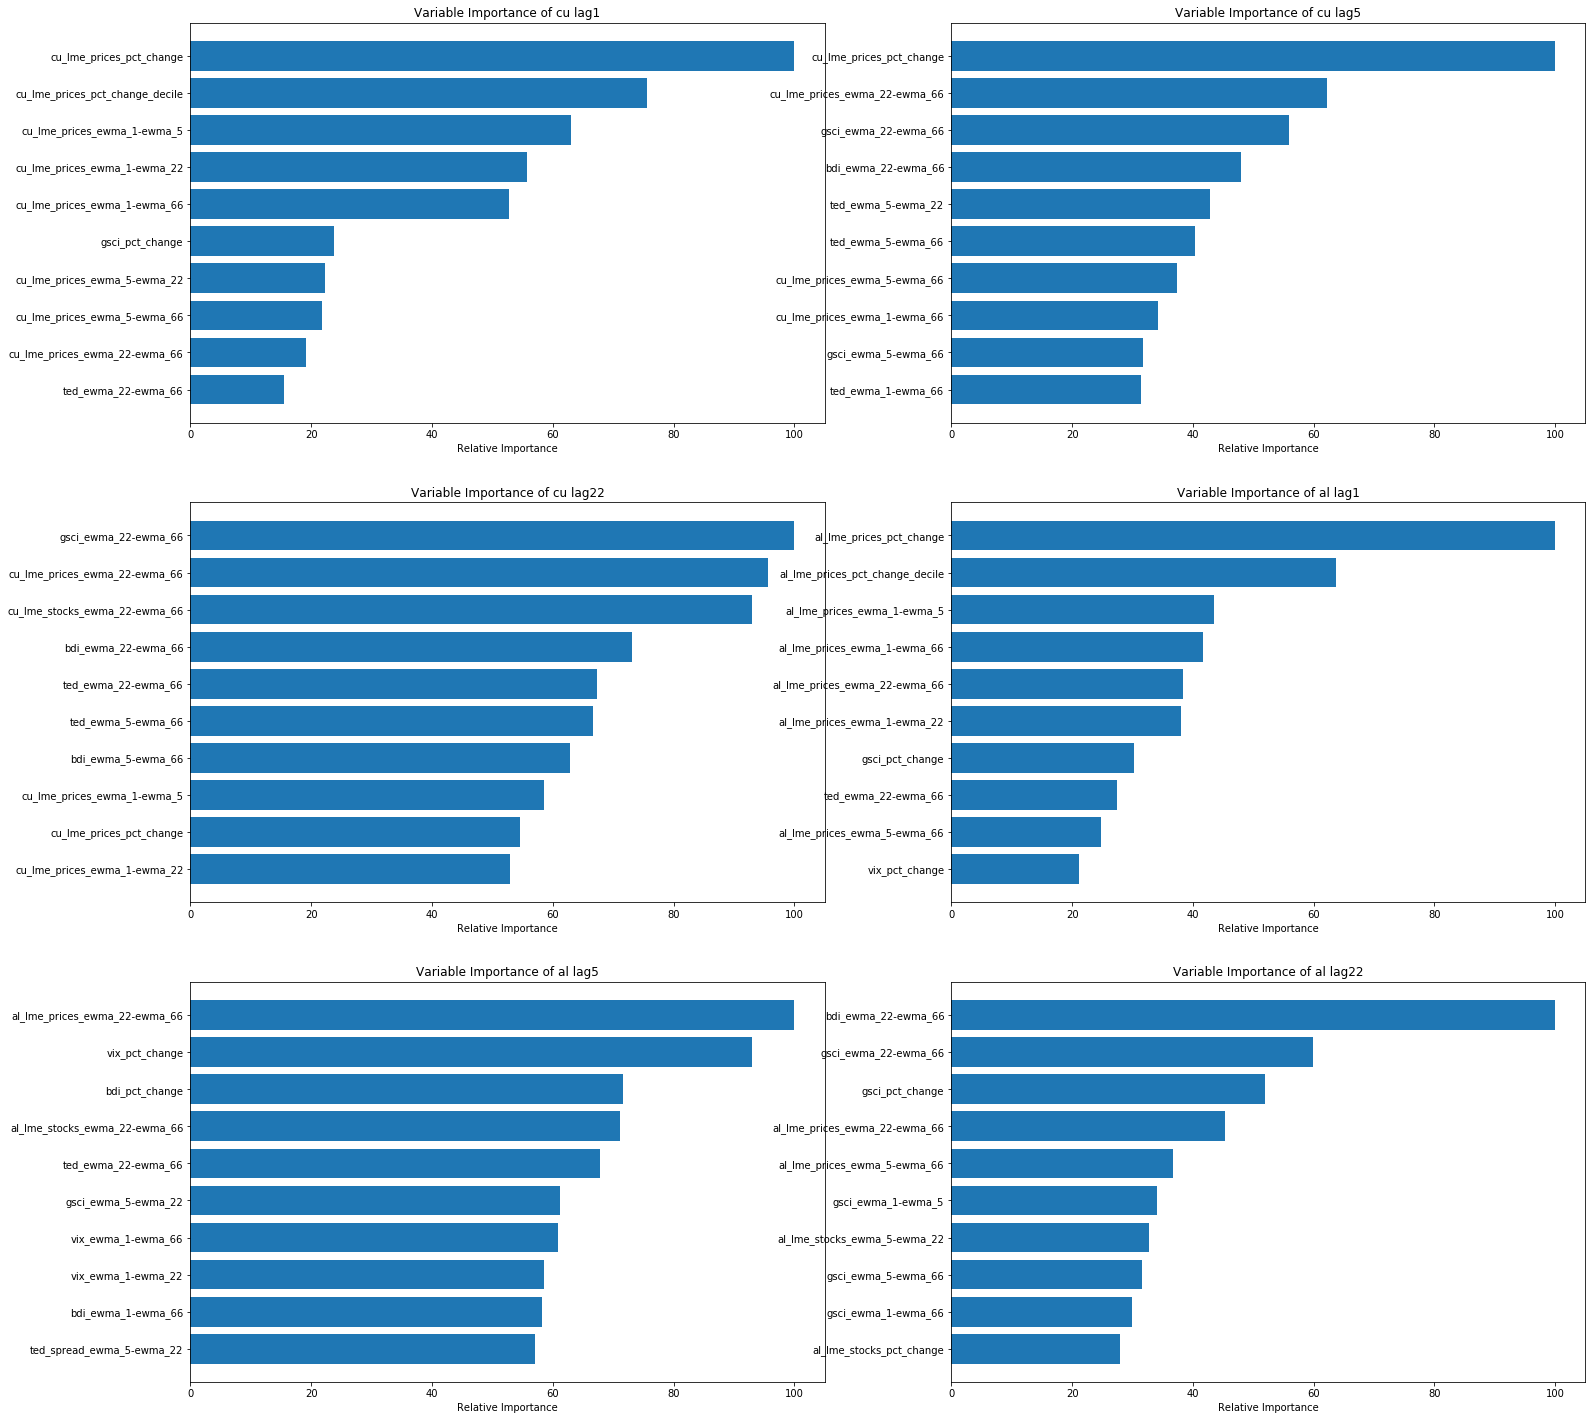

In [252]:
def boosting_selection(data_set_boosting):
    fig = plt.figure(figsize=(25,25))
    importance = {}
    for i,data in enumerate(data_set_boosting):
        
        X_train,X_test,y_train,y_test = split_data(data_set_boosting[data][0],0.2)
        
        model = data_set_boosting[data][1]
        feature_importance = model.feature_importances_
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        importance[data] = X_train.columns[sorted_idx][::-1]
        plt.subplot(3,2,i+1)
        pos = np.arange(10) +0.5
        plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
        plt.yticks(pos, X_train.columns[sorted_idx][-10:])
        plt.xlabel('Relative Importance')
        plt.title('Variable Importance of %s'%data)
    plt.show()
    fig.savefig('boosting_feature_import.png')
    return importance
boosting_importance = boosting_selection(data_set_boosting)

Text(0,0.5,'Deviance')

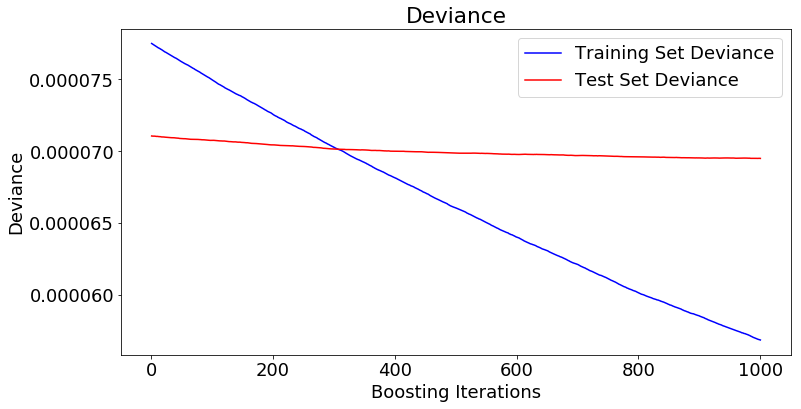

In [362]:
X_train,X_test,y_train,y_test =split_data(al_lag22,0.2)
model = ensemble.GradientBoostingRegressor(n_estimators = 1000,learning_rate=0.001,\
                                           max_depth = 10,max_features=10,min_samples_leaf=10,\
                                          min_samples_split=10)
model.fit(X_train,y_train)
test_score = np.zeros((1000), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(1000) + 1, model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(1000) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# feature selection result

In [253]:
def add_feature(name,number):
    temp1 = uni_selection_result[name]['f regression'][::-1][:number]
    temp2 = uni_selection_result[name]['mutual info'][::-1][:number]
    temp3 = boosting_importance[name][:number]
    temp4 = linear_rank(models_fwd[name].\
                        loc[forward_result[name]['AIC_number'],'model'].params,number)
    list_of_lists = [temp1,temp2,temp3,temp4]
    flattened_list1 = [y for x in list_of_lists for y in x]
    unique_elements, counts_elements = np.unique(flattened_list1, return_counts=True)
    return unique_elements, counts_elements


def linear_rank(temp1,number):
    temp2 = []
    temp3 = []
    for i in temp1.keys():
        temp2.append(temp1[i])
        temp3.append(i)
    temp2 = np.array(temp2)
    temp3 = np.array(temp3)
    sorted_idx = np.argsort(temp2)
    return temp3[sorted_idx][::-1][:number]

In [254]:
final_selection = {'cu lag1':[],'cu lag5':[],'cu lag22':[],'al lag1':[],'al lag5':[],'al lag22':[]}
for name in final_selection.keys():
    final_selection[name] = {}
    final_selection[name]['feature'],final_selection[name]['times']\
    = add_feature(name,5)

In [281]:
a = {'feature':final_selection['al lag22']['feature'],\
     'selected times':final_selection['al lag22']['times']}
b = pd.DataFrame(data = a)

In [277]:
b.columns

Index(['feature', 'selected times'], dtype='object')

In [282]:
b.sort_values(by=['selected times'],ascending = False)

feature  selected times
0            al_lme_prices_decile               3
6             bdi_ewma_22-ewma_66               2
8                     gsci_decile               2
12                     ted_decile               2
13             vix_ewma_5-ewma_22               2
1   al_lme_prices_ewma_22-ewma_66               1
2    al_lme_prices_ewma_5-ewma_66               1
3            al_lme_stocks_decile               1
4        al_lme_stocks_pct_change               1
5                      bdi_decile               1
7              bdi_ewma_5-ewma_66               1
9             gsci_ewma_1-ewma_66               1
10           gsci_ewma_22-ewma_66               1
11                gsci_pct_change               1

# multi-task gaussian regression

In [532]:
import csv

In [525]:
# experiment2
total = pd.concat([cu_lag1[['cu_lme_prices_pct_change','gsci_pct_change','bdi_pct_change']],\
                   al_lag1['al_lme_prices_pct_change'],\
                  cu_lag1['CLOSE']],\
                 axis = 1)
total = total.merge(al_lag1['CLOSE'].to_frame(),left_index=True, right_index=True)
total = total.dropna()

x = total.drop(['CLOSE_x','CLOSE_y'],axis = 1)
y = total[['CLOSE_x','CLOSE_y']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

np.savetxt('x_train_cu_lag1_all',np.array(X_train),delimiter=",")
np.savetxt('x_test_cu_lag1_all',np.array(X_test),delimiter=",")
np.savetxt('y_train_cu_lag1_all',np.array(y_train),delimiter=",")

In [363]:
##with the same trend
# total = cu_lag1.merge(al_lag1['CLOSE'].to_frame(),left_index=True, right_index=True)
# total = total.dropna()
# x = total.drop(['CLOSE_x','CLOSE_y'],axis = 1)
# y = total[['CLOSE_x','CLOSE_y']]
# index = []
# for i in final_selection['cu lag1']['feature']:
#     index.append(x.columns.get_loc(i))
# x = np.array(x)[:,index]
# new_x = []
# new_y_cu = []
# new_y_al = []
# for i in range(len(y)):
#     if y['CLOSE_x'][i]*y['CLOSE_y'][i]>=0:
#         new_y_cu.append(y['CLOSE_x'][i])
#         new_y_al.append(y['CLOSE_y'][i])
#         new_x.append(x[i,:])
# new_y_cu = np.array(new_y_cu)
# new_y_al = np.array(new_y_al)
# new_x = np.array(new_x)
# new_y = np.matrix([new_y_cu,new_y_al]).T
# X_train, X_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.2, random_state=42)
# np.savetxt('x_train_cu_lag1_sa',X_train,delimiter=",")
# np.savetxt('x_test_cu_lag1_sa',X_test,delimiter=",")
# np.savetxt('y_train_cu_lag1_sa',y_train,delimiter=",")
# np.savetxt('y_test_cu_lag1_sa',y_test,delimiter=",")

# # correlation=0.84
# print (mean_squared_error(ypre['co'],y_test[:,0]),mean_squared_error(ypre['al'],y_test[:,1]),\
#       stats.spearmanr(ypre['co'],y_test[:,0]),stats.spearmanr(ypre['al'],y_test[:,1]))
# print (mean_squared_error(ypre_train['co'],y_train[:,0]),mean_squared_error(ypre_train['al'],y_train[:,1]),\
#       stats.spearmanr(ypre_train['co'],y_train[:,0]),stats.spearmanr(ypre_train['al'],y_train[:,1]))

In [365]:
# single GPR 
length = np.ones(len(final_selection['cu lag1']['feature']))*1
kernel = 1.0 * RBF(length_scale=length)+WhiteKernel(1e-4)
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X_test,y_test[:,0])
y_pre = gp.predict(X_test)
y_pre_test = gp.predict(X_train)
print (mean_squared_error(y_pre_test,y_train[:,0]),mean_squared_error(y_pre,y_test[:,0]),\
       stats.spearmanr(y_pre_test,y_train[:,0]),stats.spearmanr(y_pre,y_test[:,0]))

0.00012269064833406615 8.82541823164006e-05 SpearmanrResult(correlation=0.6368842253837049, pvalue=1.8001877727189912e-160) SpearmanrResult(correlation=0.6487181212664741, pvalue=2.6634851079772274e-43)


In [399]:
# single GPR 
length = np.ones(len(final_selection['al lag1']['feature']))*1
kernel = 1.0 * RBF(length_scale=length)+WhiteKernel(1e-4)
X_train, X_test, y_train, y_test = split_data(al_lag1,0.2)
X_train = X_train[final_selection['al lag1']['feature']]
X_test = X_test[final_selection['al lag1']['feature']]
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X_test,y_test)
y_pre = gp.predict(X_test)
y_pre_test = gp.predict(X_train)
print (mean_squared_error(y_pre_test,y_train),mean_squared_error(y_pre,y_test),\
       stats.spearmanr(y_pre_test,y_train),stats.spearmanr(y_pre,y_test))

6.321215736413486e-05 5.9958934585907434e-05 SpearmanrResult(correlation=0.4390833163607767, pvalue=1.4886867927333518e-106) SpearmanrResult(correlation=0.4755091790812897, pvalue=4.7668714357459275e-33)


In [491]:
# experiment1
total = cu_lag5.merge(al_lag5['CLOSE'].to_frame(),left_index=True, right_index=True)
total = total.dropna()
x = total.drop(['CLOSE_x','CLOSE_y'],axis = 1)
y = total[['CLOSE_x','CLOSE_y']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# feature_list = ['gsci_pct_change_lags22','vix_pct_change_lags22','bdi_pct_change_lags22',\
#                'ted_spread_pct_change_lags22','ted_pct_change_lags22']
X_train = X_train[final_selection['cu lag5']['feature']]
X_test = X_test[final_selection['cu lag5']['feature']]
# np.savetxt('x_train_cu_lag5',np.array(X_train),delimiter=",")
# np.savetxt('x_test_cu_lag5',np.array(X_test),delimiter=",")
# np.savetxt('y_train_cu_lag5',np.array(y_train),delimiter=",")
# np.savetxt('y_test_cu_lag5',np.array(y_test),delimiter=",") 

In [692]:
# for i in final_selection['cu lag1']:
#     corr,_ = stats.spearmanr(x[i],y['CLOSE_x'])
#     print ("%s"%i +"  "  + "%s"%corr)

bdi_ewma_22-ewma_66_lags1  -0.006054477687955951
cu_lme_prices_ewma_1-ewma_22_lags1  0.5255057679789232
cu_lme_prices_ewma_1-ewma_5_lags1  0.5427869257543046
cu_lme_prices_ewma_1-ewma_66_lags1  0.5206489053368489
cu_lme_prices_ewma_5-ewma_66_lags1  0.29730155613130954
cu_lme_prices_pct_change_decile_lags1  0.6011694859172481
cu_lme_prices_pct_change_lags1  0.6020097418064508
shfe_cu1_ewma_5-ewma_22_lags1  0.021417458696215683


In [523]:
#load data
ypre = pd.read_csv('ypre_cu_lag1_test_all.csv',names=['co','al'])
ypre_train = pd.read_csv('ypre_cu_lag1_train_all.csv',names=['co','al'])

In [526]:
print (mean_squared_error(ypre['co'],y_test['CLOSE_x']),mean_squared_error(ypre['al'],y_test['CLOSE_y']),\
      stats.spearmanr(ypre['co'],y_test['CLOSE_x']),stats.spearmanr(ypre['al'],y_test['CLOSE_y']))
print (mean_squared_error(ypre_train['co'],y_train['CLOSE_x']),mean_squared_error(ypre_train['al'],y_train['CLOSE_y']),\
      stats.spearmanr(ypre_train['co'],y_train['CLOSE_x']),stats.spearmanr(ypre_train['al'],y_train['CLOSE_y']))

0.00010253913666448974 6.561925309891545e-05 SpearmanrResult(correlation=0.5617115898254343, pvalue=6.304558075954212e-42) SpearmanrResult(correlation=0.3584314301338357, pvalue=3.064684742323832e-16)
7.562955391303433e-05 4.808954074226934e-05 SpearmanrResult(correlation=0.6702150163129129, pvalue=2.6729965914728503e-254) SpearmanrResult(correlation=0.561576002021911, pvalue=2.555729922524503e-162)


In [506]:
print (mean_squared_error(ypre['co'],y_train['CLOSE_x']),mean_squared_error(ypre['al'],y_train['CLOSE_y']),\
      stats.spearmanr(ypre['co'],y_train['CLOSE_x']),stats.spearmanr(ypre['al'],y_train['CLOSE_y']))
print (mean_squared_error(ypre_train['co'],y_test['CLOSE_x']),mean_squared_error(ypre_train['al'],y_test['CLOSE_y']),\
      stats.spearmanr(ypre_train['co'],y_test['CLOSE_x']),stats.spearmanr(ypre_train['al'],y_test['CLOSE_y']))

0.0001743383512005364 8.367228584498975e-05 SpearmanrResult(correlation=-0.001598482053046881, pvalue=0.9440224659548828) SpearmanrResult(correlation=-0.014440881028188754, pvalue=0.5258431029479369)
3.860218786456371e-05 2.4131584247463624e-05 SpearmanrResult(correlation=0.8760956598536753, pvalue=1.6708929797663676e-154) SpearmanrResult(correlation=0.8101977017568507, pvalue=1.1646338247241125e-113)


# toy example for gaussian process regression


In [13]:
from sklearn.linear_model import BayesianRidge, LinearRegression

In [189]:
# Generating simulated data with Gaussian weights
np.random.seed(0)
n_samples, n_features = 100, 100
X = np.random.randn(n_samples, n_features)  # Create Gaussian data
# Create weights with a precision lambda_ of 4.
lambda_ = 10.
w = np.zeros(n_features)
# Only keep 10 weights of interest
relevant_features = np.random.randint(0, n_features, 10)
for i in relevant_features:
    w[i] = stats.norm.rvs(loc=0, scale=1. / np.sqrt(lambda_))
# Create noise with a precision alpha of 50.
alpha_ = 100.
noise = stats.norm.rvs(loc=0, scale=1. / np.sqrt(alpha_), size=n_samples)
# Create the target
y = np.dot(X, w) + noise

x_train = X[:80]
y_train = y[:80]

x_test = X[80:]
y_test = y[80:]

In [200]:
ols = LinearRegression()
ols.fit(x_train, y_train)
clf = BayesianRidge(compute_score=True)
clf.fit(x_train, y_train)
kernel = 1.0 * RBF(length_scale=10) + WhiteKernel(1e-4)
gp2 = GaussianProcessRegressor(kernel=kernel)
gp2.fit(x_train, y_train)

length = np.ones(n_features)*10
kernel = 1.0 * RBF(length_scale=length) + WhiteKernel(1e-4)
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(x_train, y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]) + WhiteKernel(noise_level=0.0001),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [88]:
# gp.kernel_.get_params()

In [201]:
y_ols = ols.predict(x_test)
y_clf = clf.predict(x_test)
y_gp = gp.predict(x_test)
y_gp2 = gp2.predict(x_test)
print (mean_squared_error(y_ols,y_test),mean_squared_error(y_clf,y_test),\
      mean_squared_error(y_gp2,y_test),mean_squared_error(y_gp,y_test))

0.16551952847060697 0.16485075438364755 0.11662114118199103 0.040159272265556586


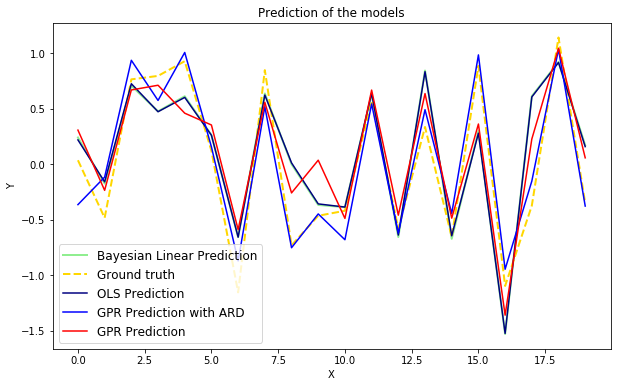

In [202]:
lw = 2
fig = plt.figure(figsize=(10, 6))
plt.title("Prediction of the models")
plt.plot(y_clf, color='lightgreen', linewidth=lw,
         label="Bayesian Linear Prediction")
plt.plot(y_test, color='gold',linestyle='--', linewidth=lw, label="Ground truth")
plt.plot(y_ols, color='navy',label="OLS Prediction")
plt.plot(y_gp, color='blue', label="GPR Prediction with ARD")
plt.plot(y_gp2, color='red', label="GPR Prediction")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="best", prop=dict(size=12))
plt.show()
fig.savefig('three_method_result')

In [6]:
from sklearn.preprocessing import StandardScaler

In [203]:
length_scale=[1e+05, 1e+05, 1e+05, 5.77e+04, 1e+05, 1.9e+04, 1e+05, 1.22e+03, 1e+05, 406, 1e+05, 1e+05, 70.4, 1e+05, 366, 1e+05, 40.2, 1e+05, 1e+05, 30.8, 36.9, 1e+05, 137, 717, 1e+05, 1e+05, 232, 1e+05, 8.86, 1e+05, 8.14e+04, 1e+05, 108, 38.8, 183, 244, 274, 62.6, 1e+05, 1e+05, 9.39e+04, 1e+05, 6.65, 1e+05, 1e+05, 1e+05, 1e+05, 8.99e+04, 1e+05, 1e+05, 9.77e+04, 1.81e+03, 5.68e+04, 1e+05, 1e+05, 1e+05, 1e+05, 1e+05, 254, 1e+05, 1e+05, 1e+05, 9.95e+04, 1e+05, 922, 1e+05, 1e+05, 7.47e+04, 8.45e+04, 1e+05, 1e+05, 462, 1e+05, 1e+05, 8.37e+04, 16.5, 1e+05, 1e+05, 386, 60.7, 1e+05, 1e+05, 1e+05, 60.2, 242, 9.99e+04, 1e+05, 213, 538, 382, 396, 1e+05, 26.4, 1e+05, 1e+05, 1e+05, 158, 1e+05, 1e+05, 1e+05]

In [204]:
length_scale = np.ones(len(length_scale))/np.array(length_scale)
length_scale = np.reshape(length_scale,(-1,1))
scaler = StandardScaler()
scaler.fit(length_scale)
norm_length_scale = scaler.transform(length_scale)

In [205]:
scaler = StandardScaler()
clf.coef = np.reshape(clf.coef_,(-1,1))
scaler.fit(clf.coef)
norm_clf= scaler.transform(clf.coef)
scaler = StandardScaler()
ols.coef = np.reshape(ols.coef_,(-1,1))
scaler.fit(ols.coef)
norm_ols= scaler.transform(ols.coef)
scaler = StandardScaler()
w = np.reshape(w,(-1,1))
scaler.fit(w)
norm_w = scaler.transform(w)

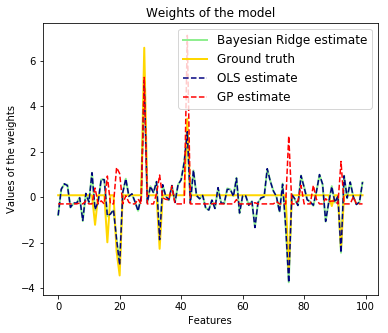

In [211]:
lw = 2
fig = plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
plt.plot(norm_clf, color='lightgreen', linewidth=lw,
         label="Bayesian Ridge estimate")
plt.plot(norm_w, color='gold', linewidth=lw, label="Ground truth")
plt.plot(norm_ols, color='navy', linestyle='--', label="OLS estimate")
plt.plot(norm_length_scale, color='red', linestyle='--', label="GP estimate")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc="best", prop=dict(size=12))
plt.show()
fig.savefig('weight_result')